In [1818]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report  
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_log_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [1819]:
df = pd.read_csv('data/train.csv', index_col=0, parse_dates=True)

In [1820]:
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [1821]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [1822]:
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [1823]:
df.isnull().values.any()

False

In [1824]:
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

### Transform the Count variable: 
* We use a logarithmic transformation to optimize the target's distribution. Idealy we want a normal distribution for linear models.

* In this way we also make sure we do not predict negative counts

<AxesSubplot:xlabel='count', ylabel='Count'>

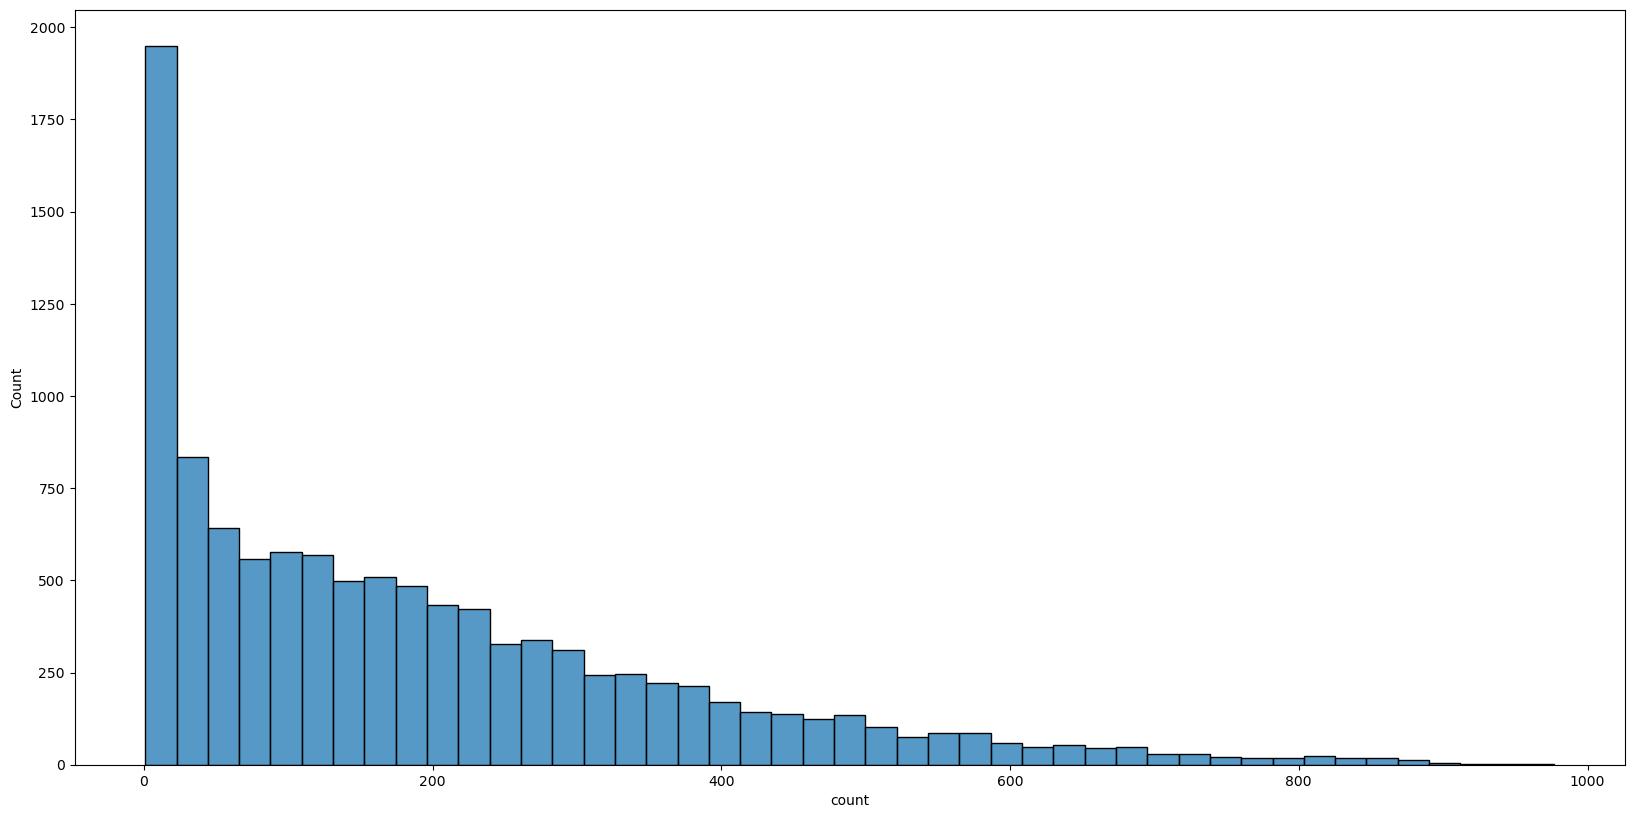

In [1825]:
plt.figure(figsize=(20,10),dpi=100)
sns.histplot(data=df, x='count')


In [1826]:
# We need to transorm our lables because their distribution is not normal:
df['count'] = np.log1p(df['count'])

<AxesSubplot:xlabel='count', ylabel='Count'>

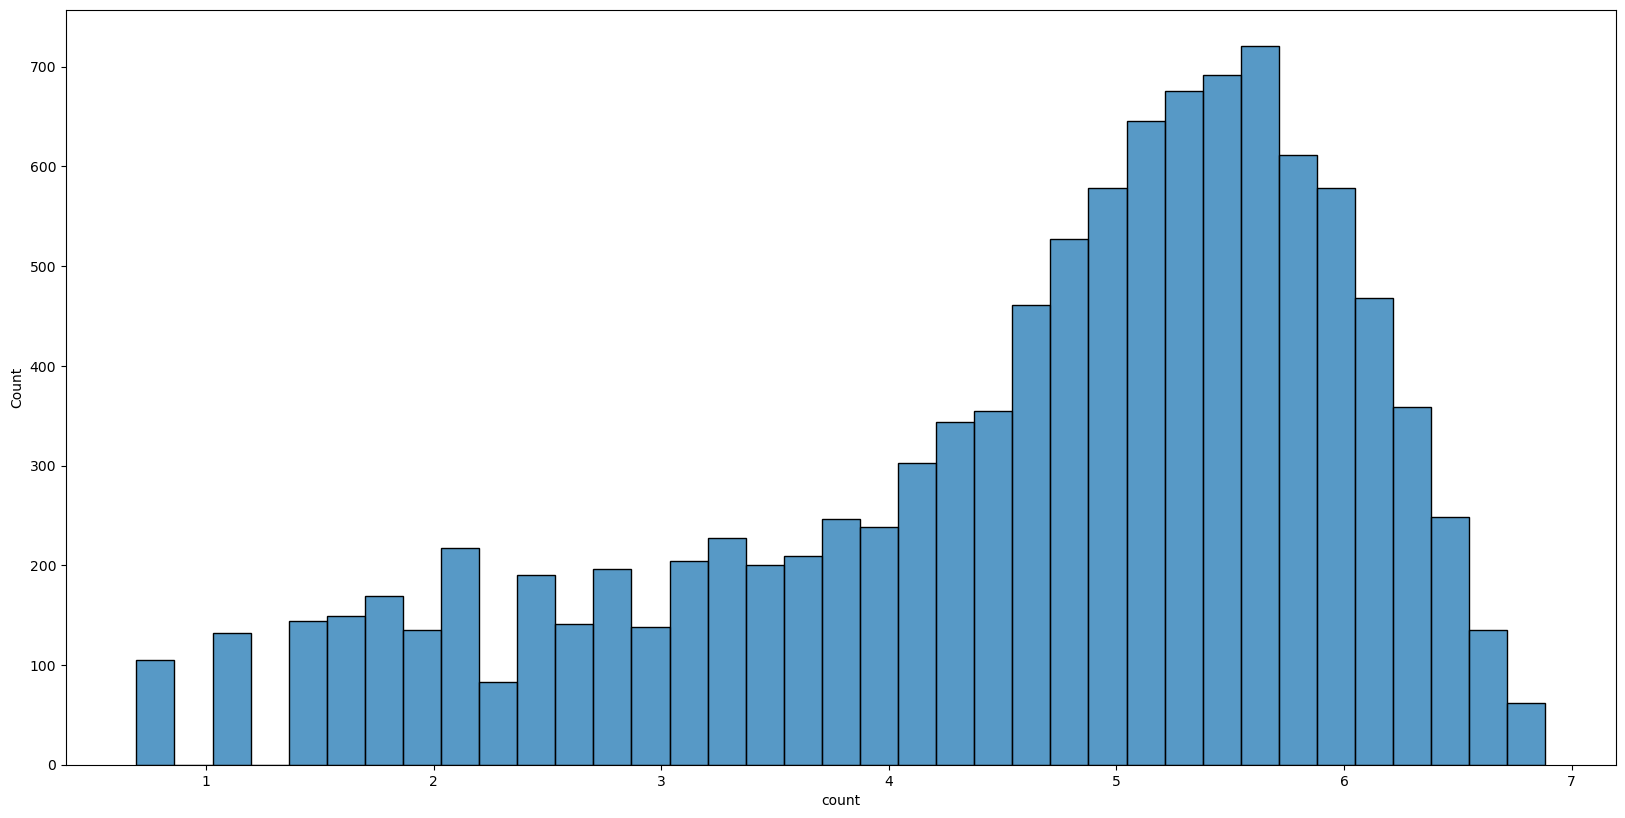

In [1827]:
plt.figure(figsize=(20,10),dpi=100)
sns.histplot(data=df, x='count')

In [1828]:
# Create datetime columns
df['hour'] = df.index.hour
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['month'] = df.index.month
df['year'] = df.index.year
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'casual', 'registered', 'count', 'hour', 'day',
       'weekday', 'month', 'year'],
      dtype='object')

## Check correlation between numerical features

In [1829]:
df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.376587
atemp,0.984948,1.000000,-0.043536,-0.057473,0.372167
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.333158
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.122754
count,0.376587,0.372167,-0.333158,0.122754,1.000000


Text(0.5, 1.0, 'Pairwise Correlation')

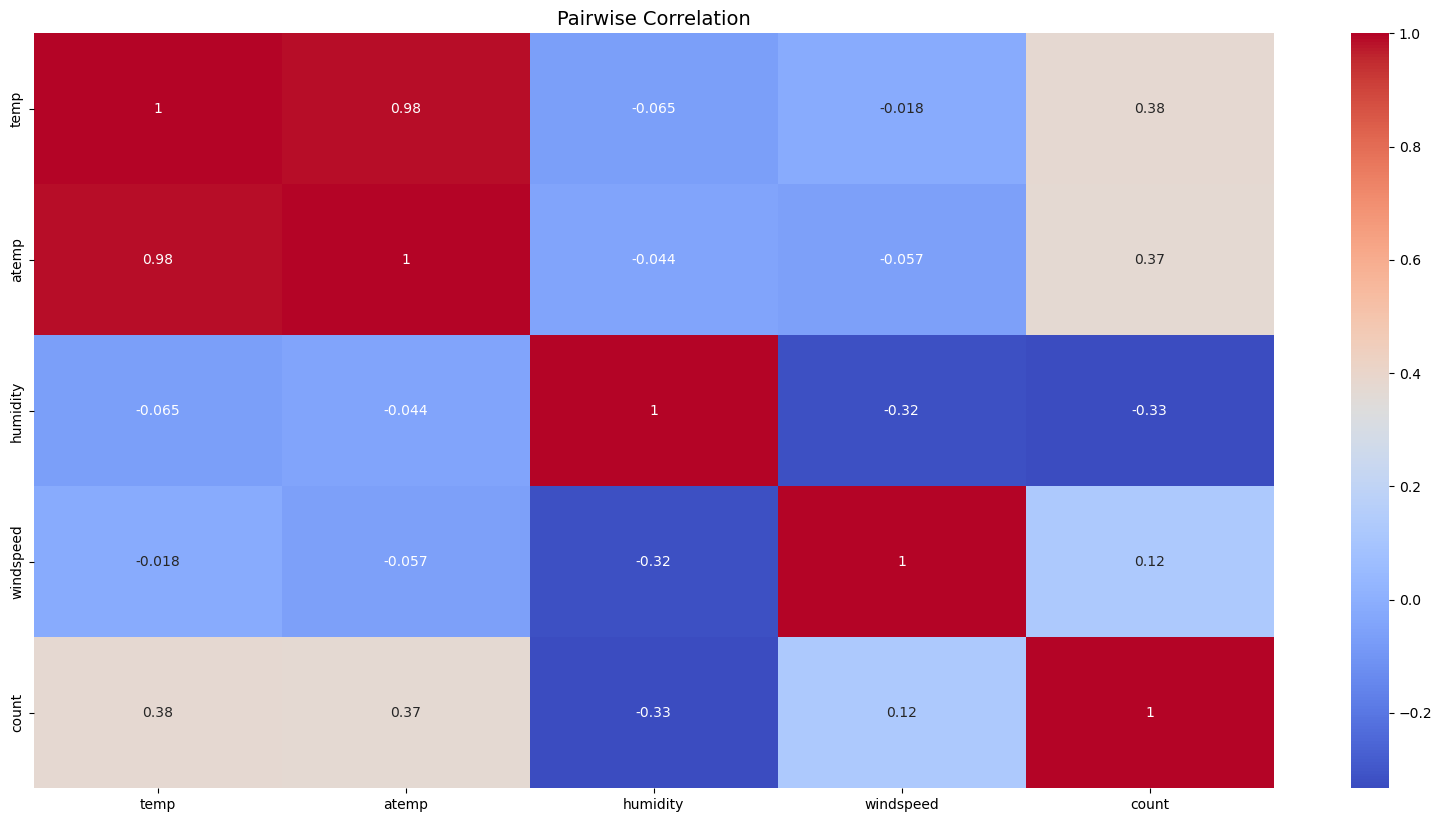

In [1830]:
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(df[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr(),cmap='coolwarm',annot=True)
plt.title('Pairwise Correlation', fontsize=14)

### Conclusions
* Temp and atemp (real feel) are high correlated, so no need to keep both. Temperature seems a tiny bit more correlated with counts so atemp can be dropded.
* Windspeed has the lower correlation with counts.

## How Weather conditions affect counts

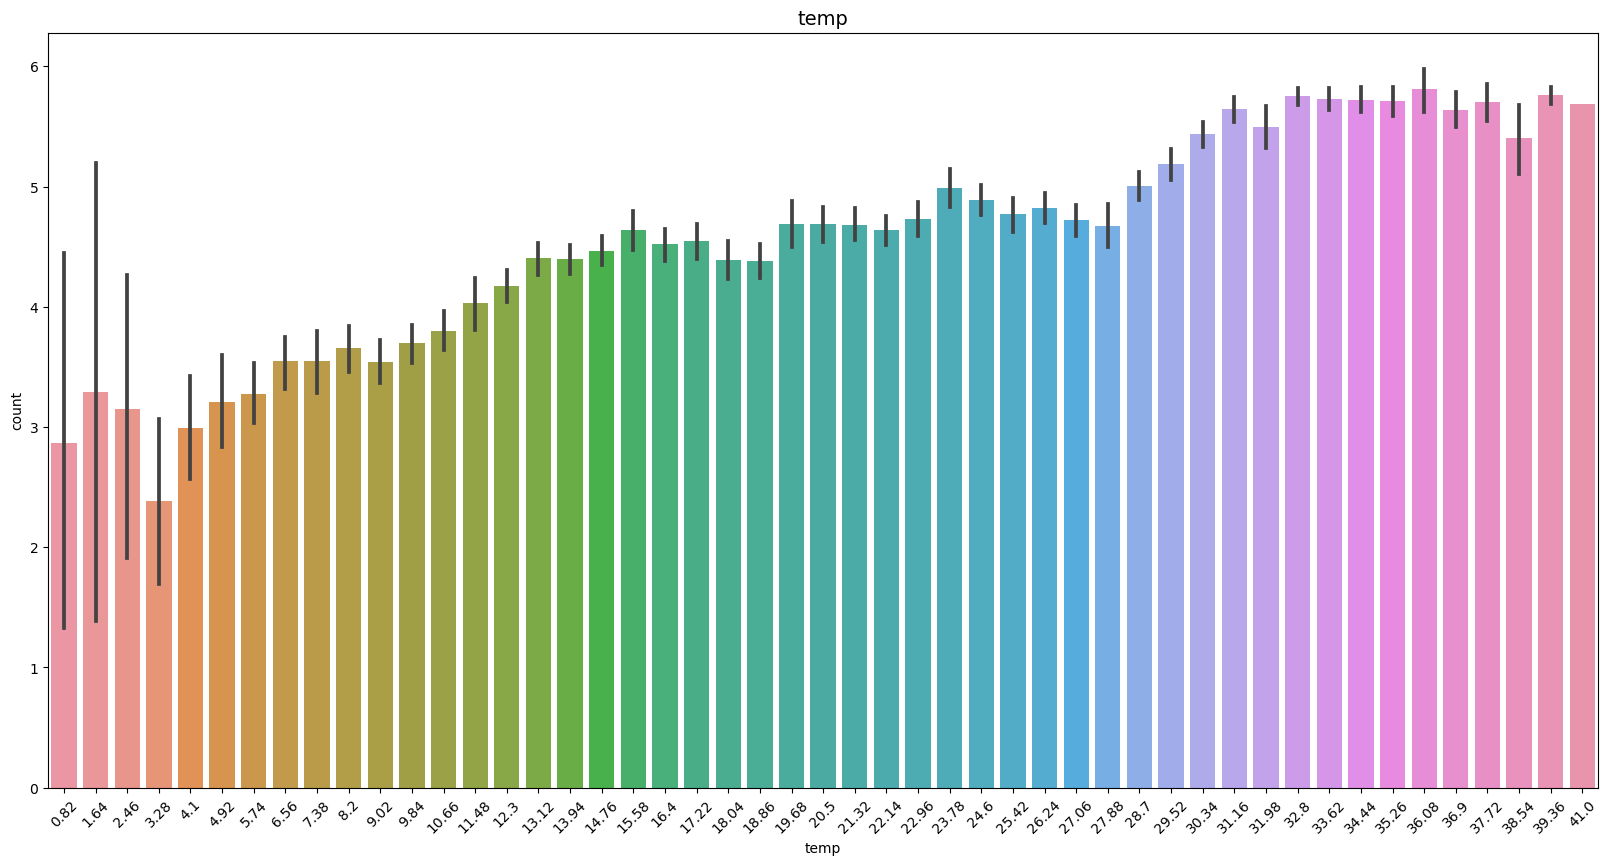

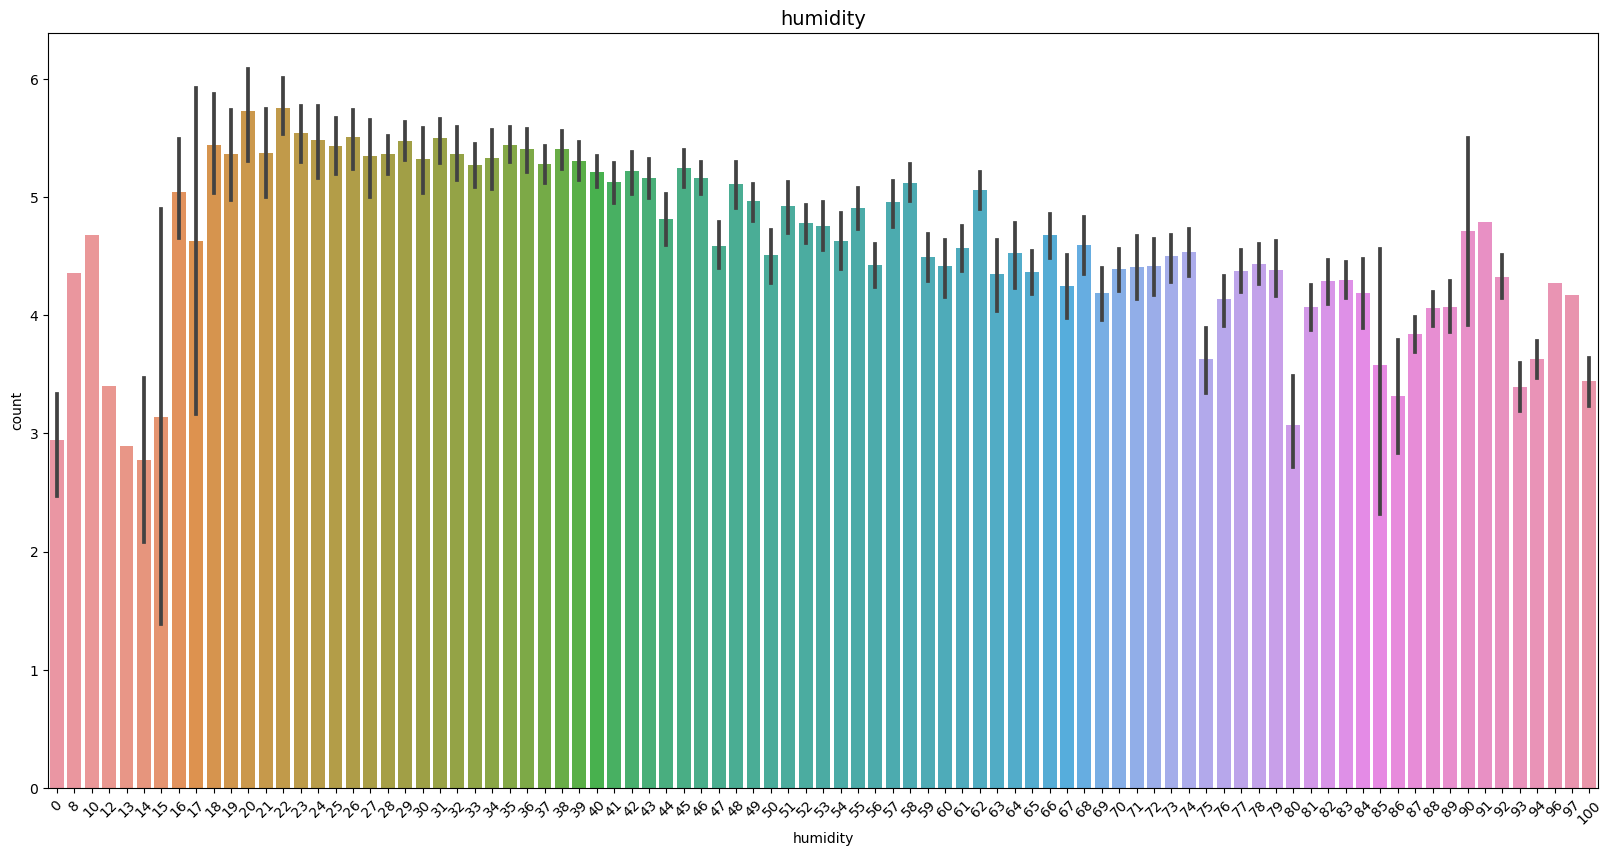

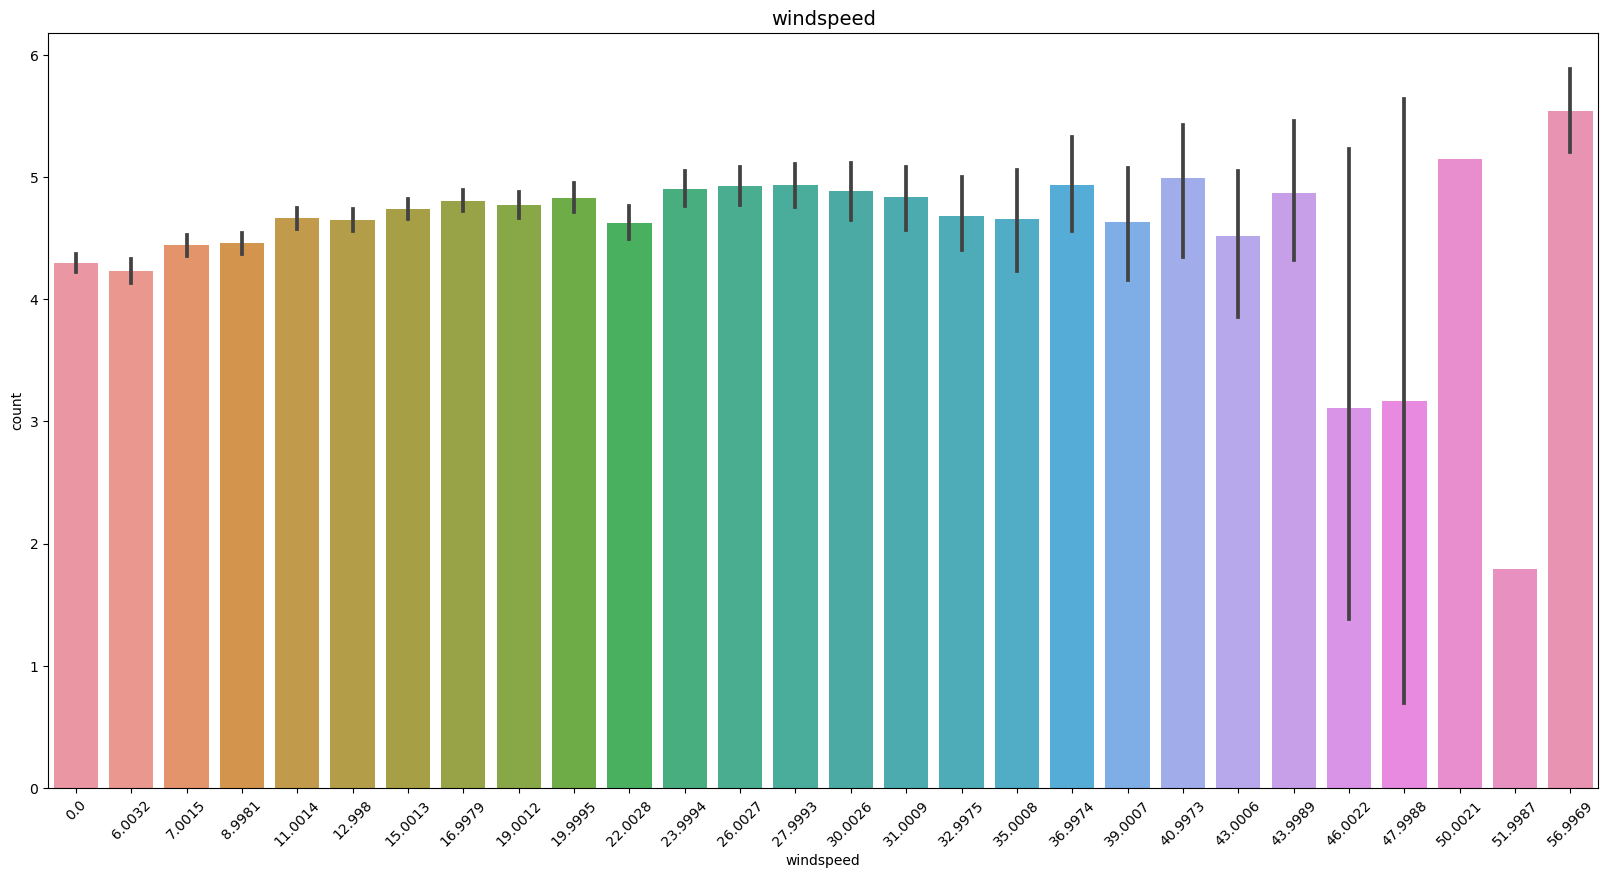

In [1831]:
for column in ['temp', 'humidity', 'windspeed']:
    plt.figure(figsize=(20,10),dpi=100)
    sns.barplot(data = df,x=column,y='count')
    plt.title(f'{column}', fontsize=14)
    plt.xticks(rotation=45)
    plt.show()

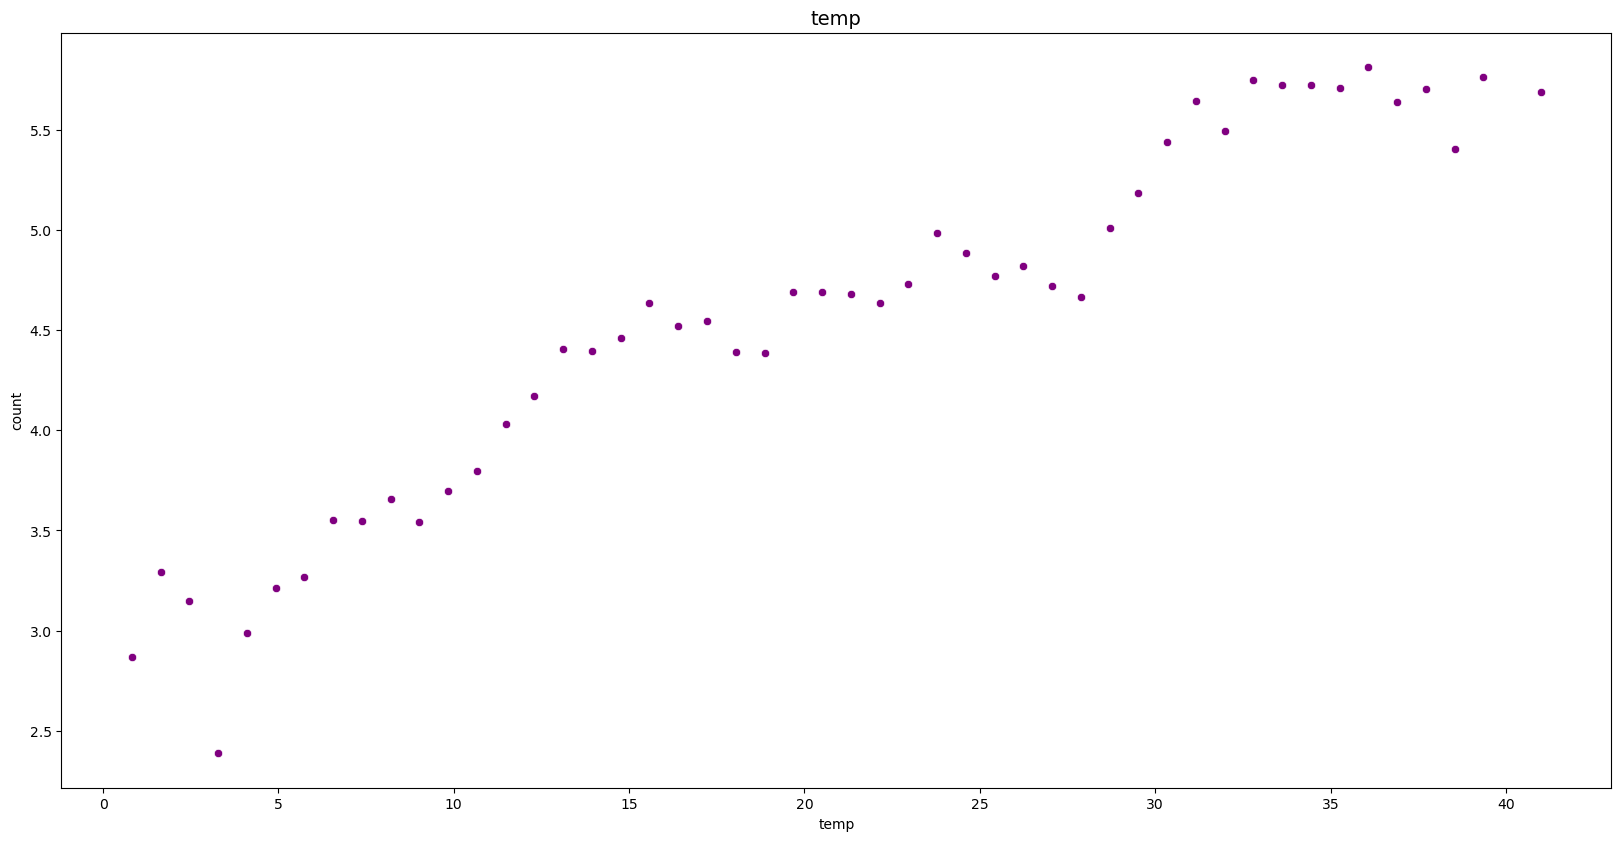

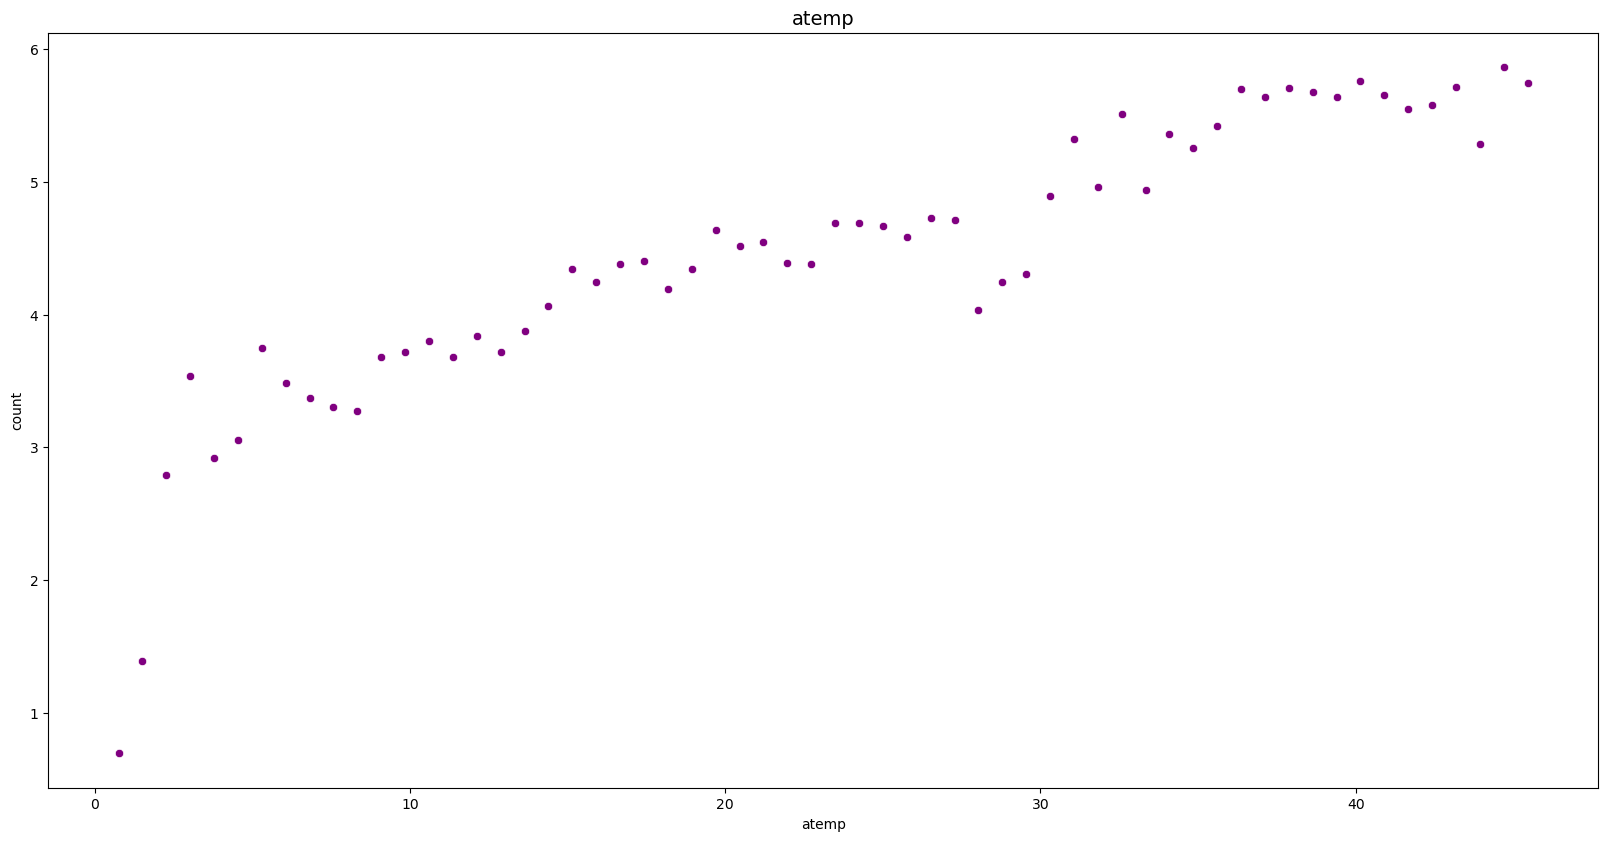

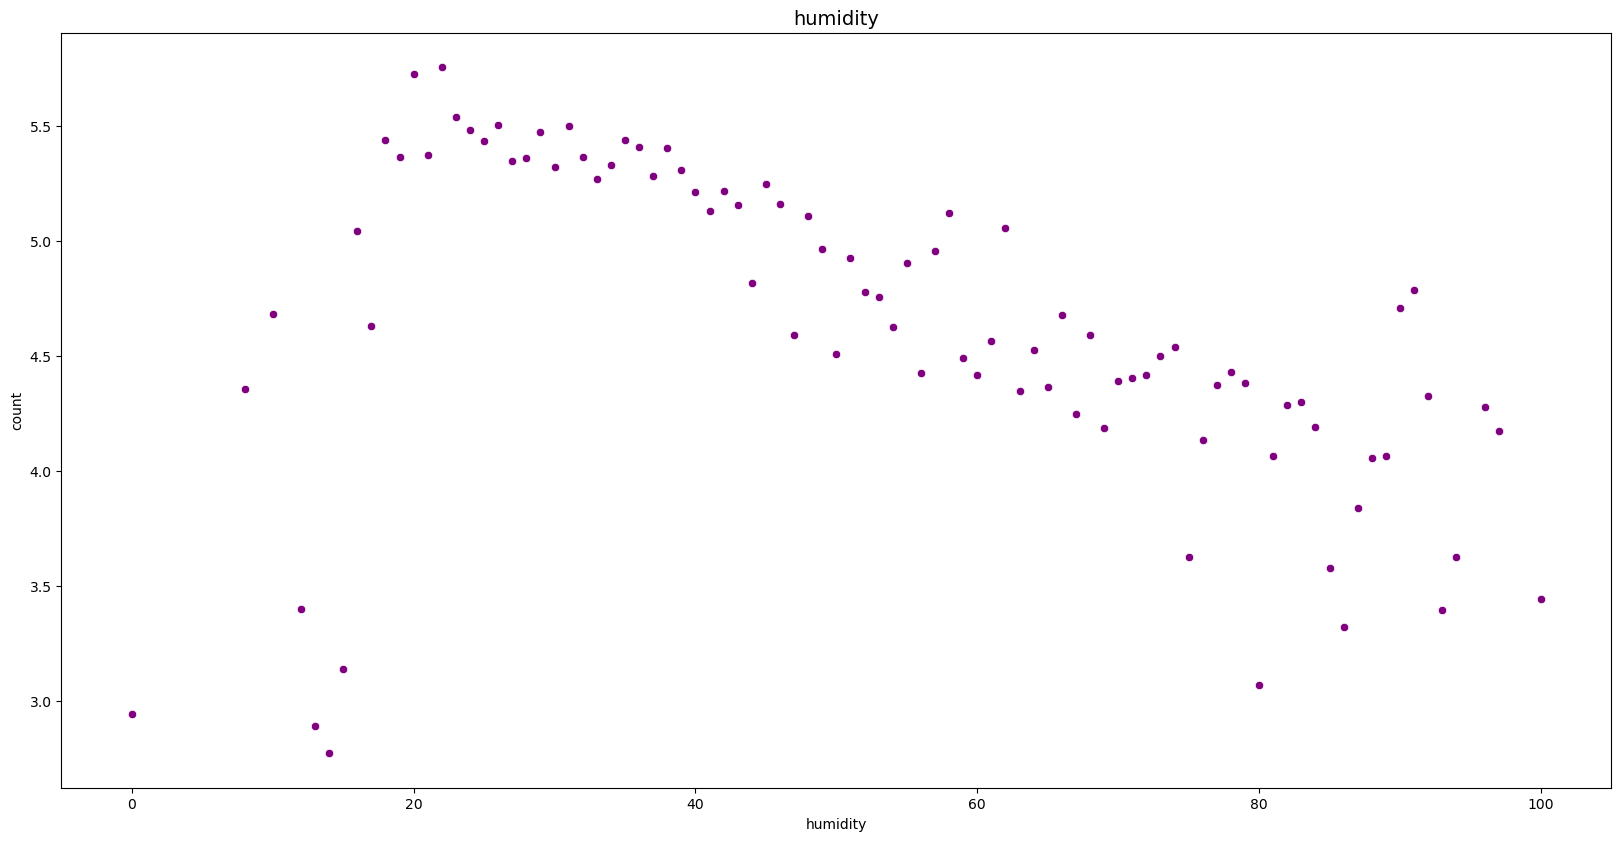

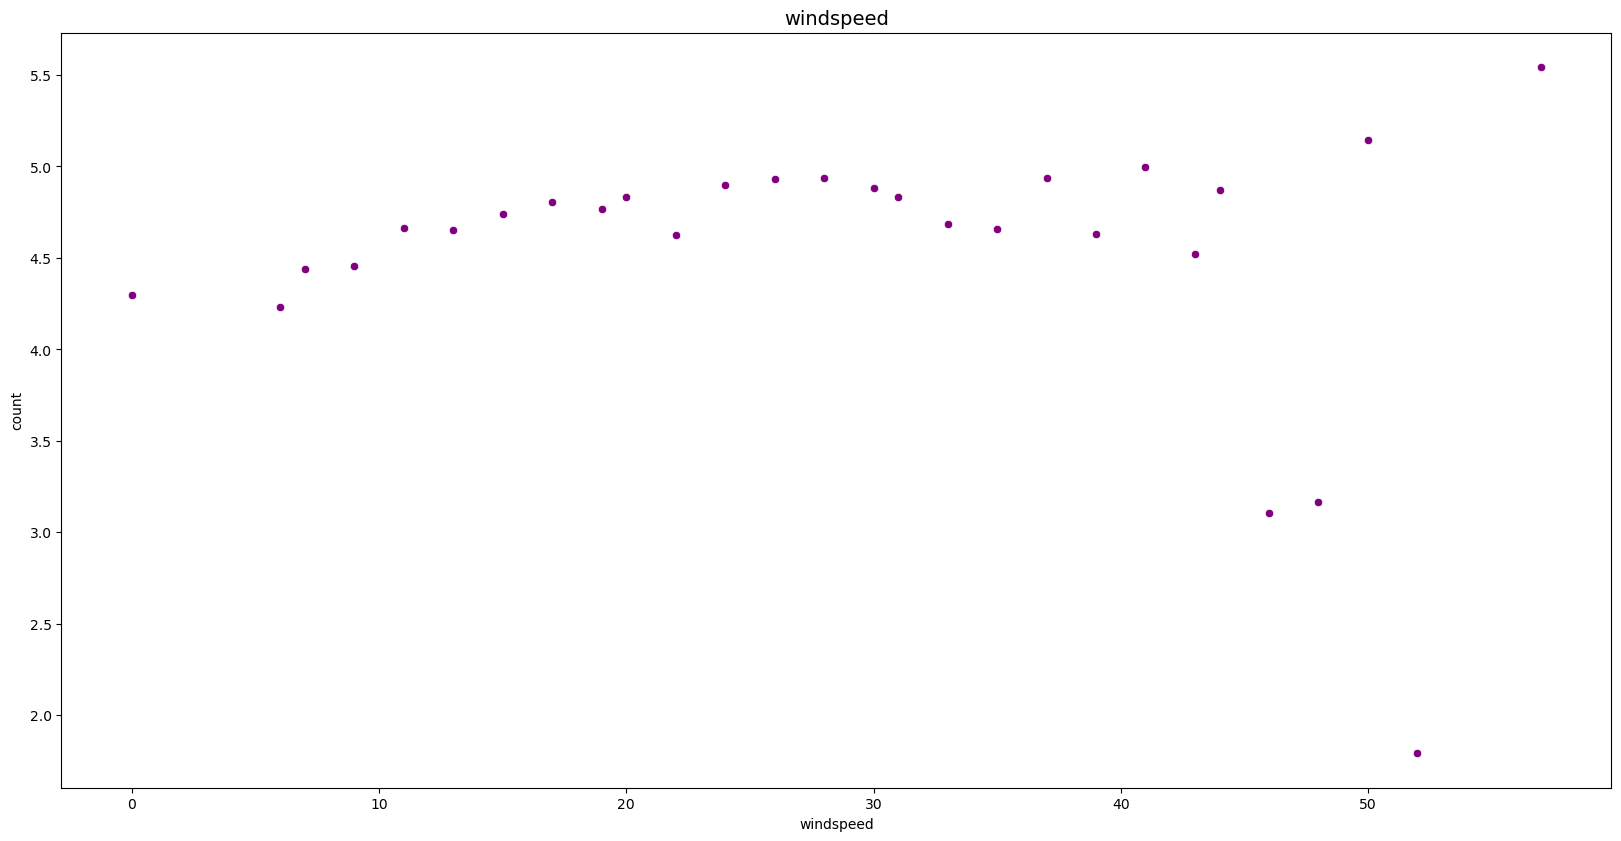

In [1832]:
for column in ['temp', 'atemp', 'humidity', 'windspeed']:
    plt.figure(figsize=(20,10),dpi=100)
    sns.scatterplot(data = df.groupby(column).mean(),x=column,y='count', color="purple")
    plt.title(f'{column}', fontsize=14)
    plt.show()

### Conlusions 
#### Temperature and real feel temperature
* Counts are low for low temperatures, increase as temperature increases. The scatter plots show a close to linear behavour, although there seems to be a plateau above 30.
#### Windspeed 
* Windspeed does not seem to affect that much the mean count. Correlation is also relattivly low (0.1 as can be seen from table above)
#### Humidity
* There is a clear drop as humitidy increases. For very low humitidy counts drop again but the "observarions" we have with low humidity are very few. Two possibilities to be investigated:
    - Too low humidity can drop real feel of temperature (https://science.howstuffworks.com/nature/climate-weather/atmospheric/question651.htm). 
    - Low counts are due to other condtitions, eg: hour of the day

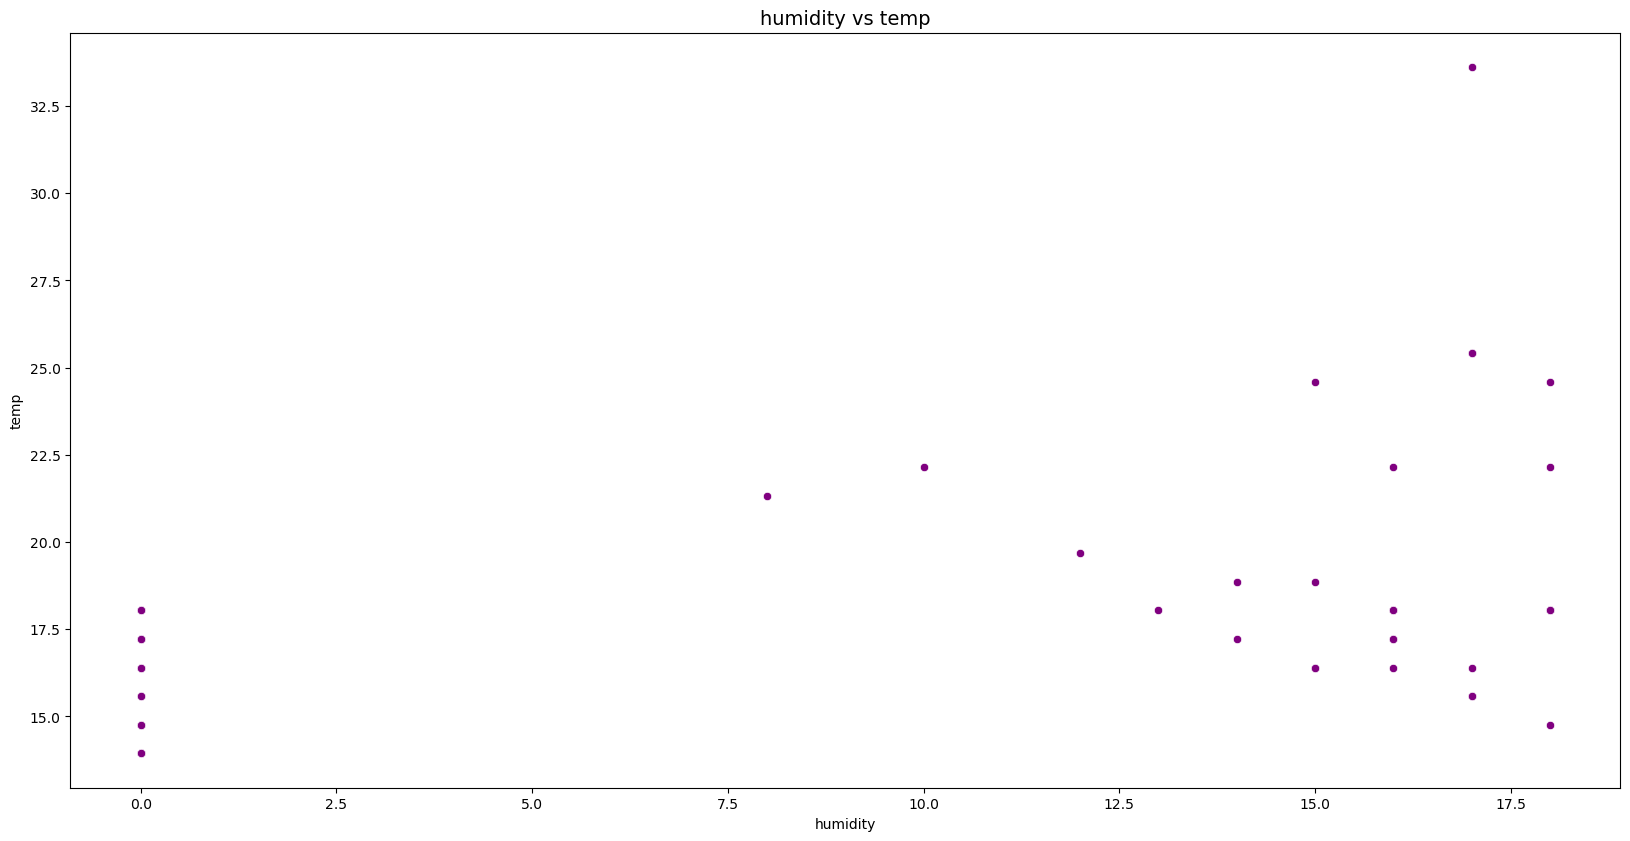

In [1833]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df[df['humidity']<=18],x='humidity',y='temp', color="purple")
plt.title(f'humidity vs temp', fontsize=14)
plt.show()

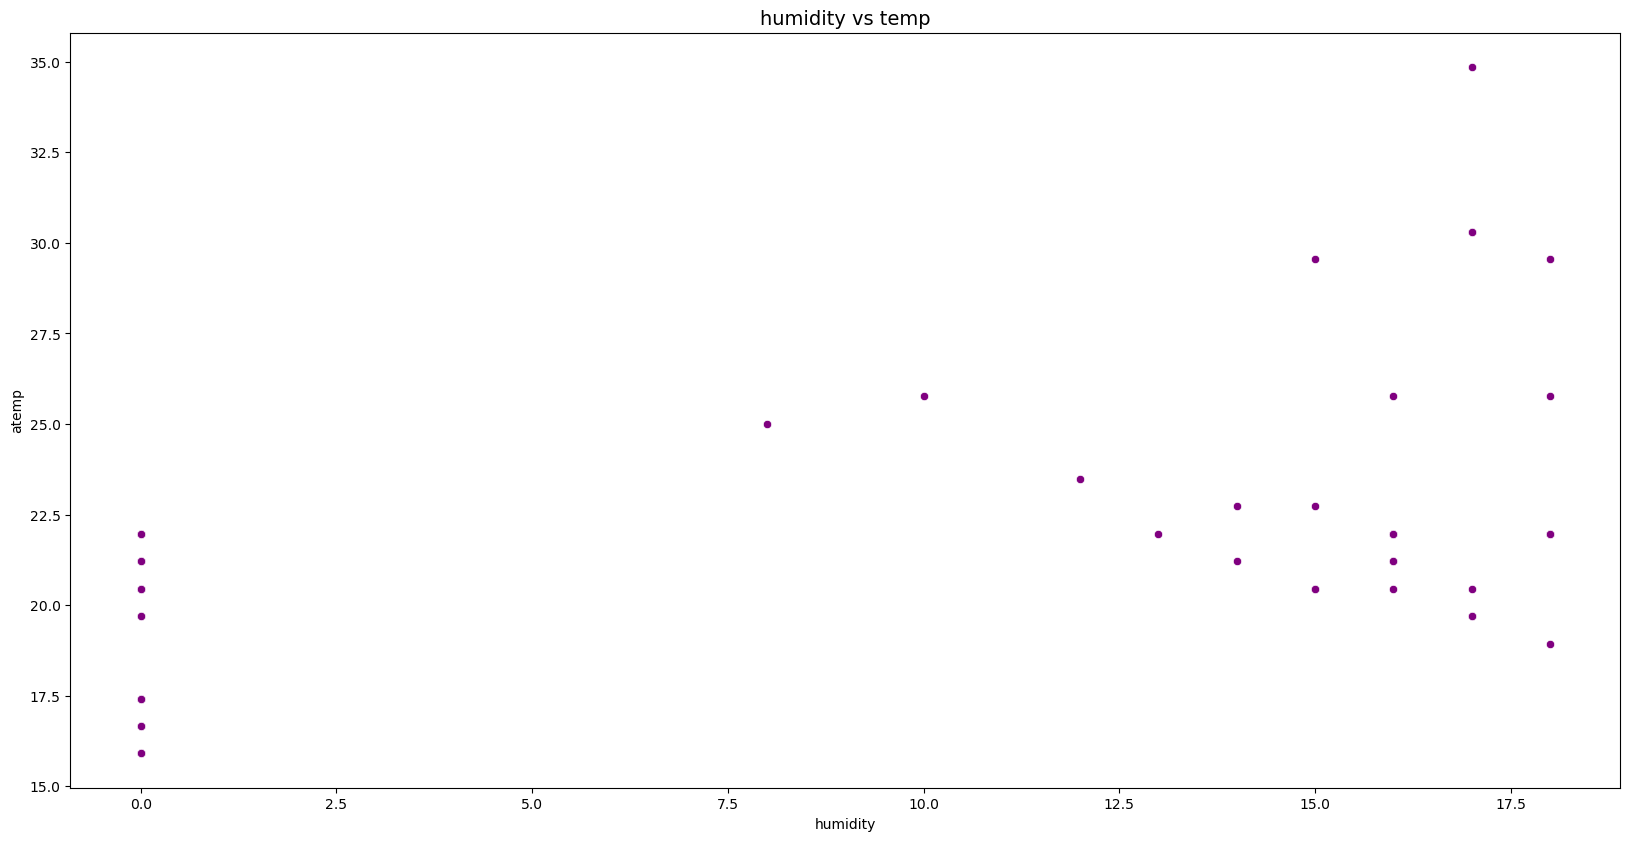

In [1834]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df[df['humidity']<=18],x='humidity',y='atemp', color="purple")
plt.title(f'humidity vs temp', fontsize=14)
plt.show()

Temperature and and real feel does not apear to differ significantly for low humidity. Thus hypothesis no1 does not seem to hold.

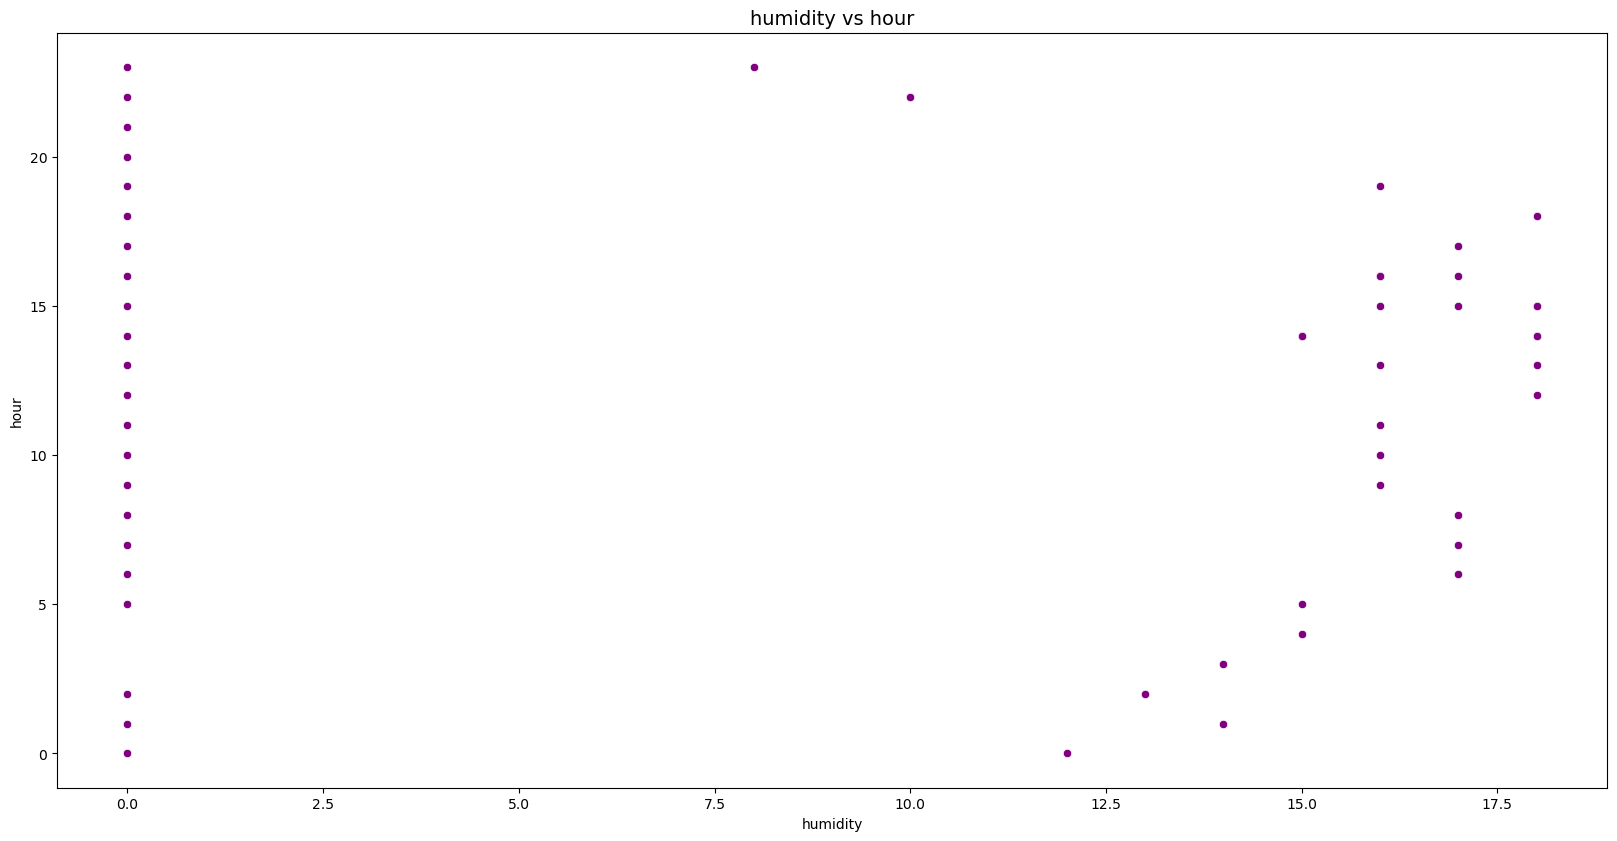

In [1835]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df[df['humidity']<=18],x='humidity',y='hour', color="purple")
plt.title(f'humidity vs hour', fontsize=14)
plt.show()

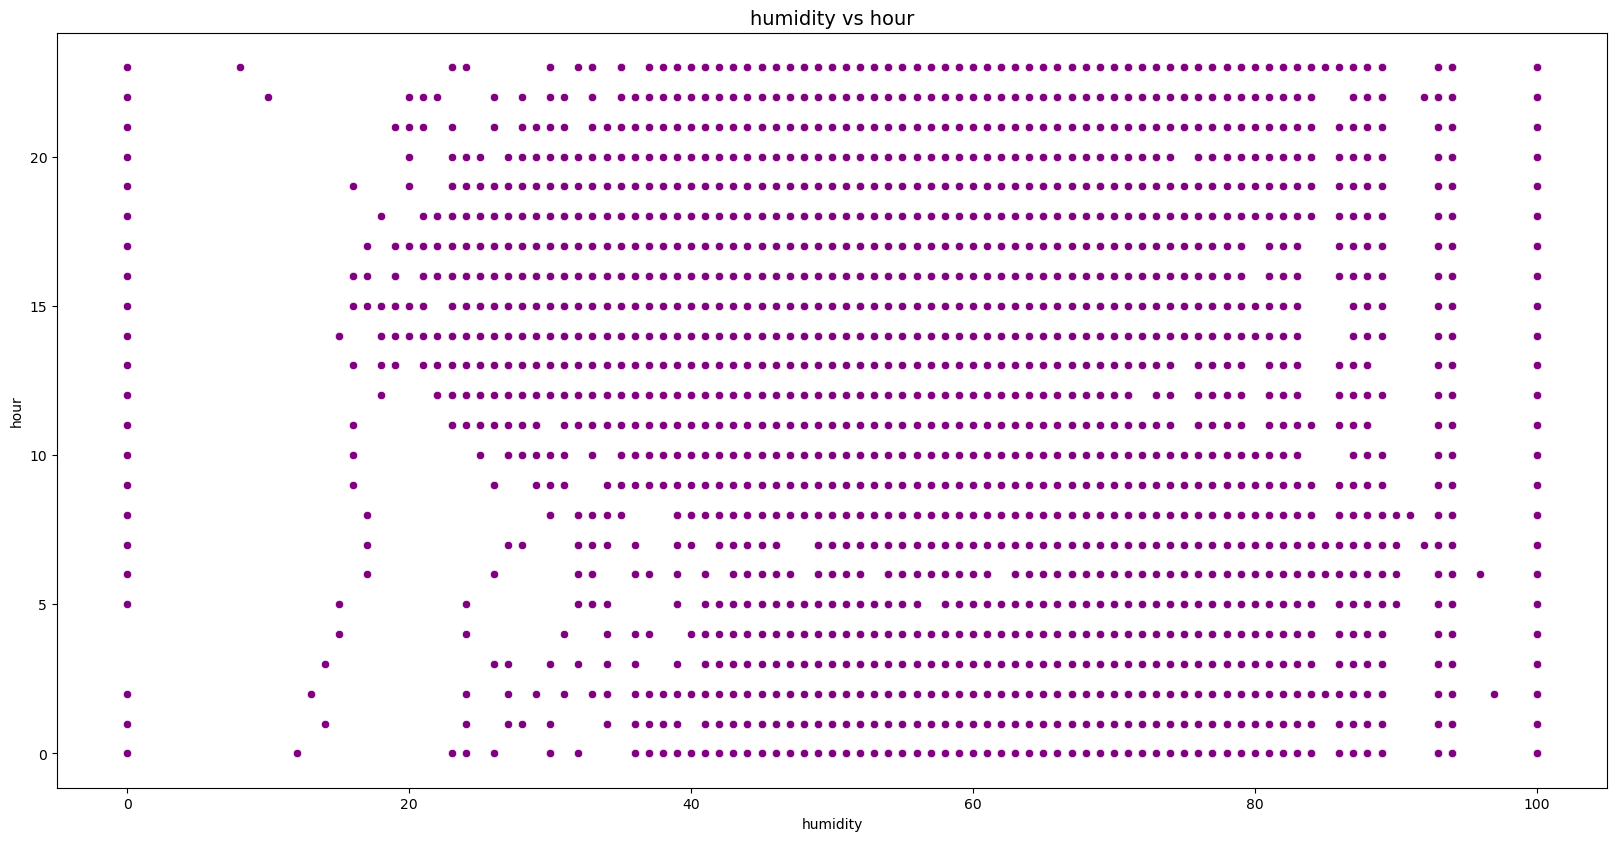

In [1836]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df,x='humidity',y='hour', color="purple")
plt.title(f'humidity vs hour', fontsize=14)
plt.show()

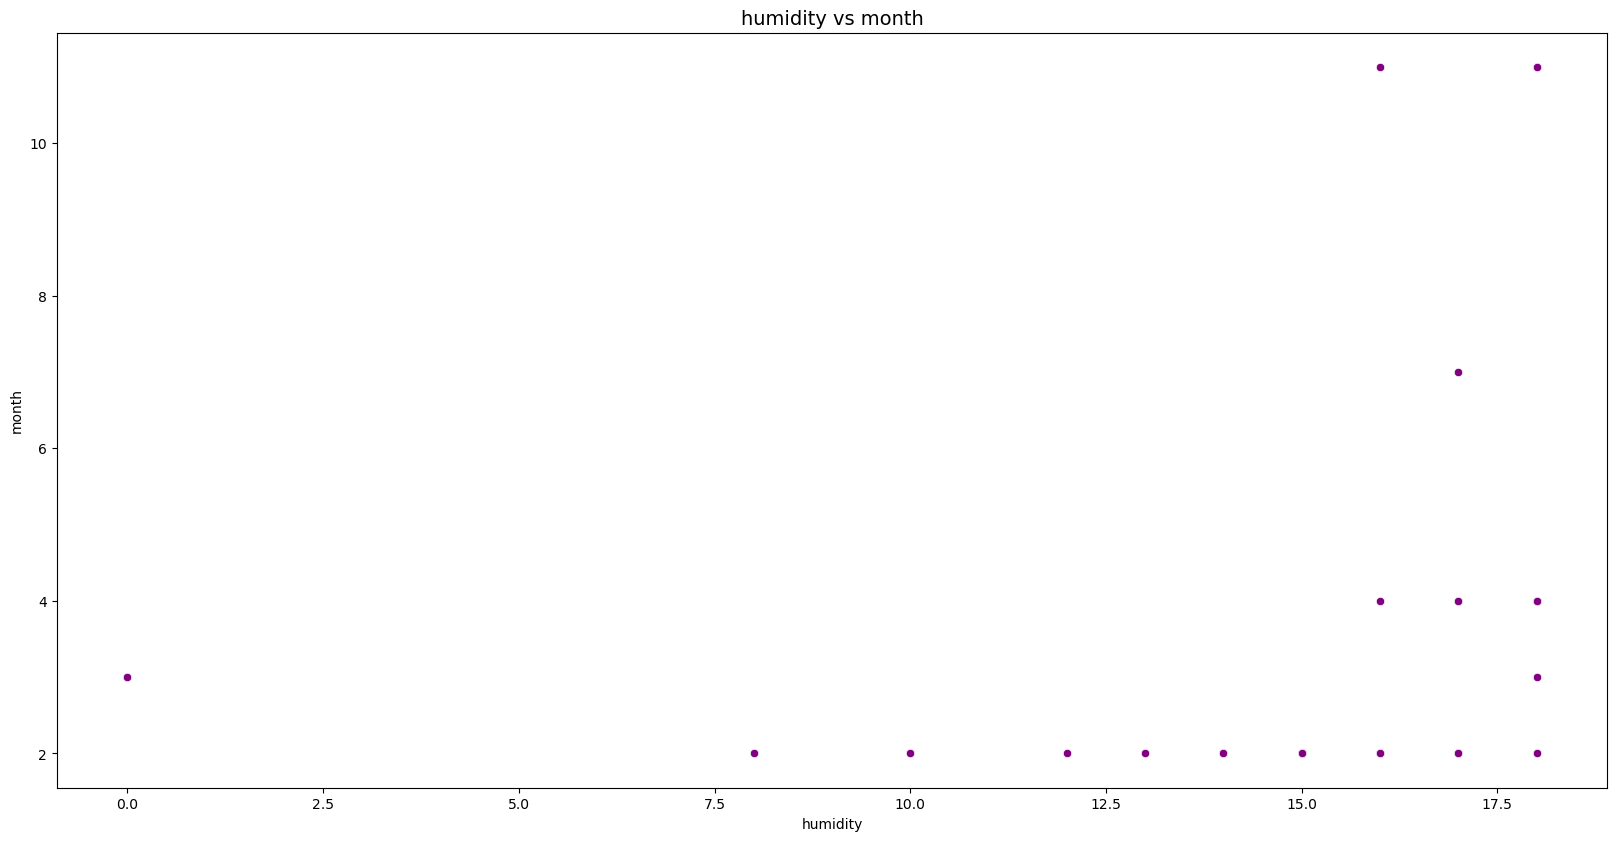

In [1837]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df[df['humidity']<=18],x='humidity',y='month', color="purple")
plt.title(f'humidity vs month', fontsize=14)
plt.show()

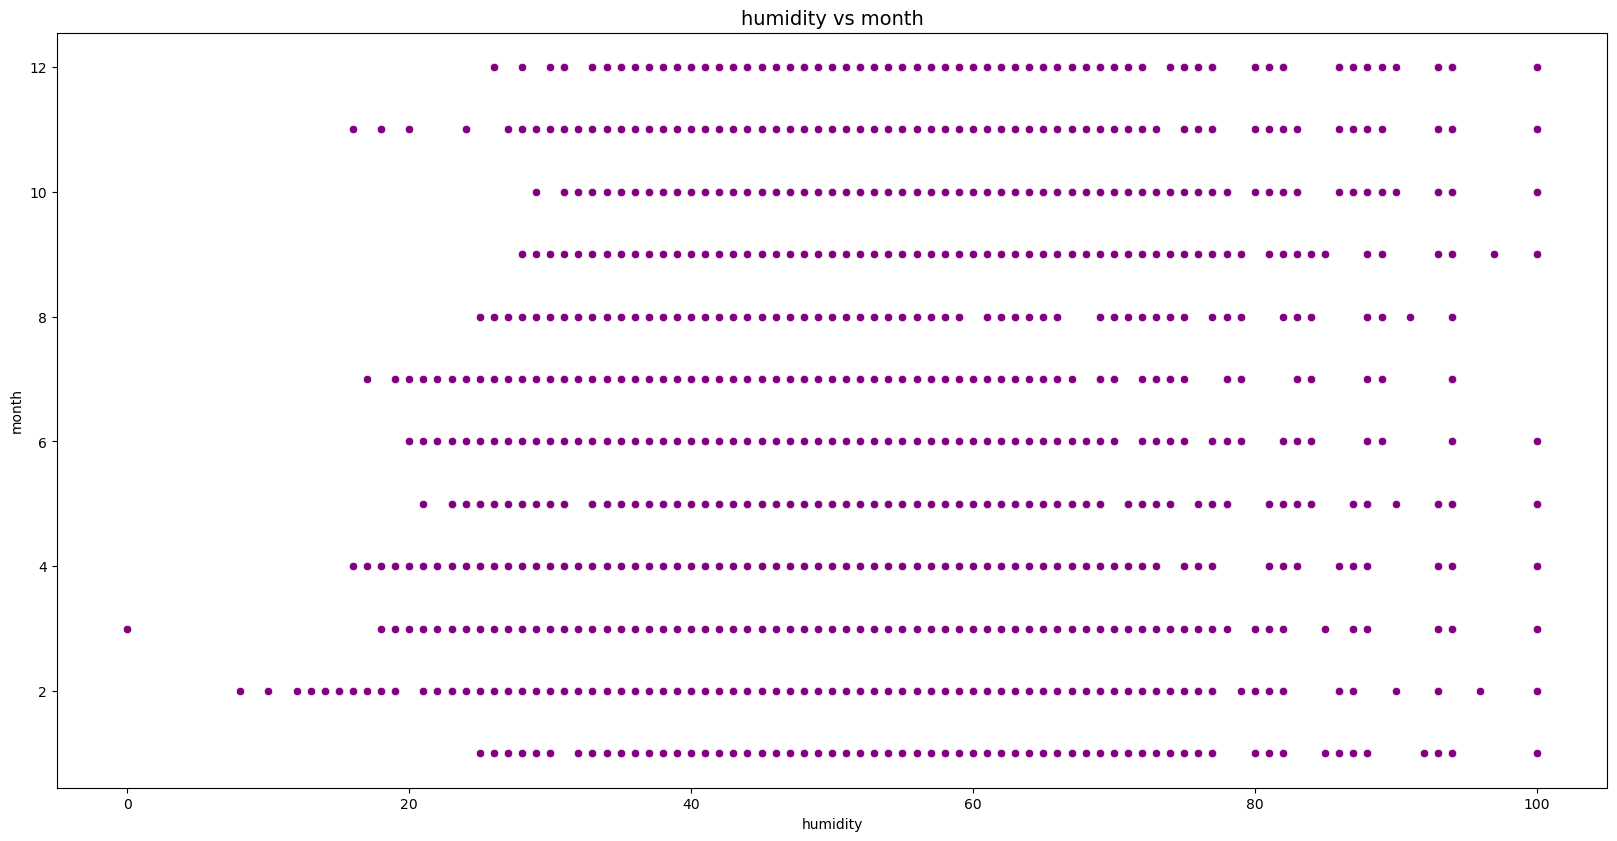

In [1838]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df,x='humidity',y='month', color="purple")
plt.title(f'humidity vs month', fontsize=14)
plt.show()

Low humidity points seem to be mostly on February and in night hours. For now we will not treat them differently and assume a linear behavour of humidity.

### What about categorical feature weather?

In [1839]:
df.groupby('weather').mean()['count']

weather
1    4.673980
2    4.545450
3    4.050533
4    5.105945
Name: count, dtype: float64

In [1840]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

There is only one weather 4. Including it to weather 3

In [1841]:
df['weather'] = df['weather'].replace(4, 3)

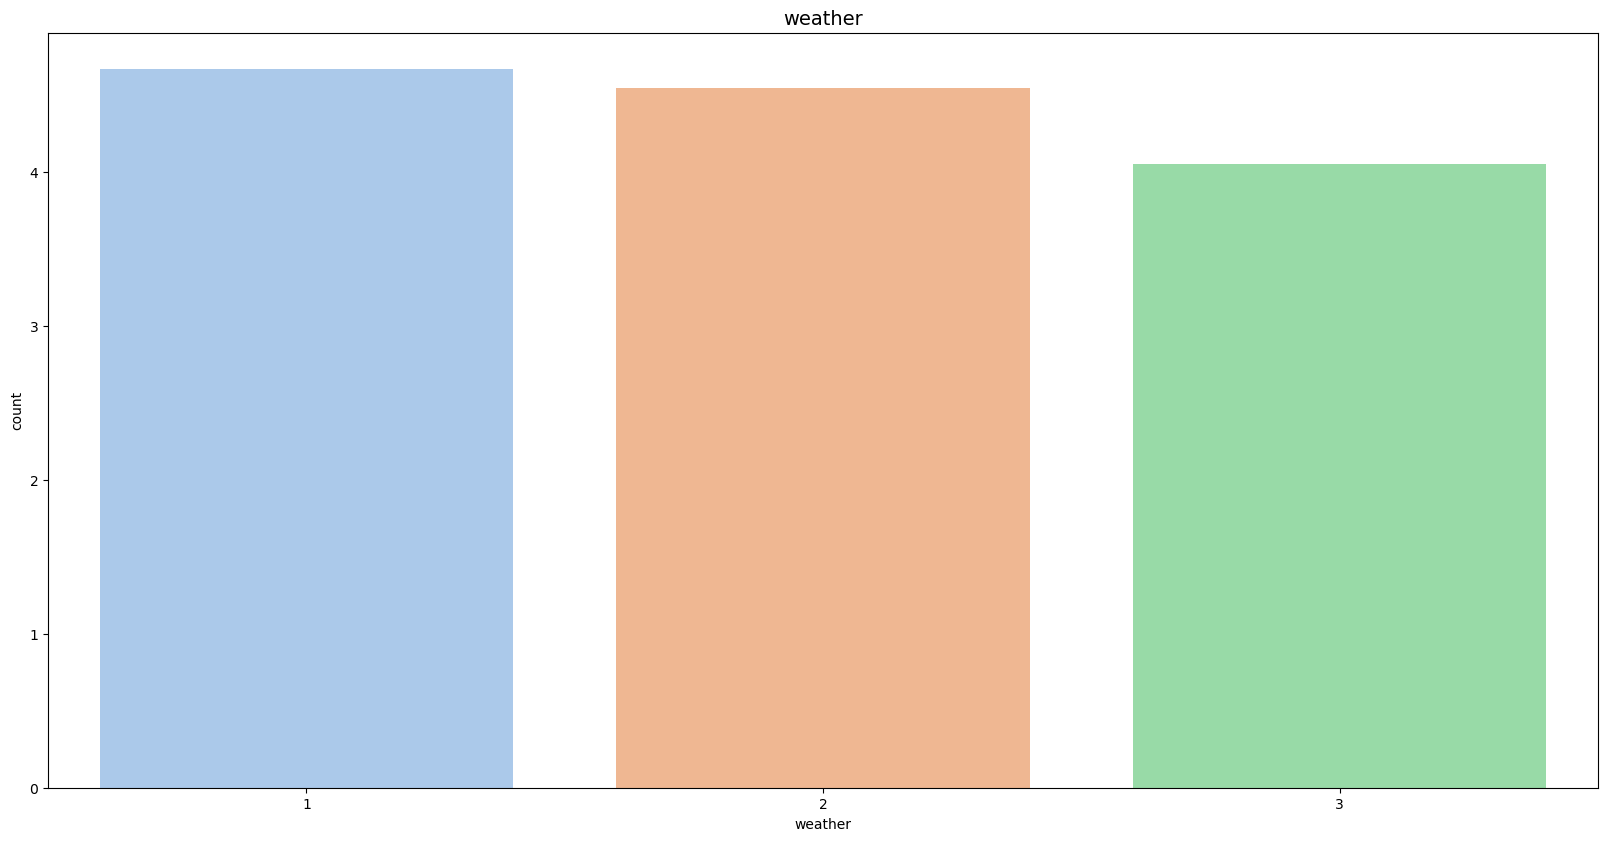

In [1842]:
plt.figure(figsize=(20,10),dpi=100)
sns.barplot(data =df.groupby('weather').mean(), x = df.groupby('weather').mean().index, y ='count', palette='pastel', )
#sns.scatterplot(data = ,x='weather',y='count')
plt.title(f'weather', fontsize=14)
plt.show()

### Conclusions
* Mean counts reduce when weather conditions are bad.

## Check correlation between categorical features

In [1843]:
# Cramers V: suggested correlation between categorical features
import scipy.stats as ss
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

Text(0.5, 1.0, 'Pairwise Correlation')

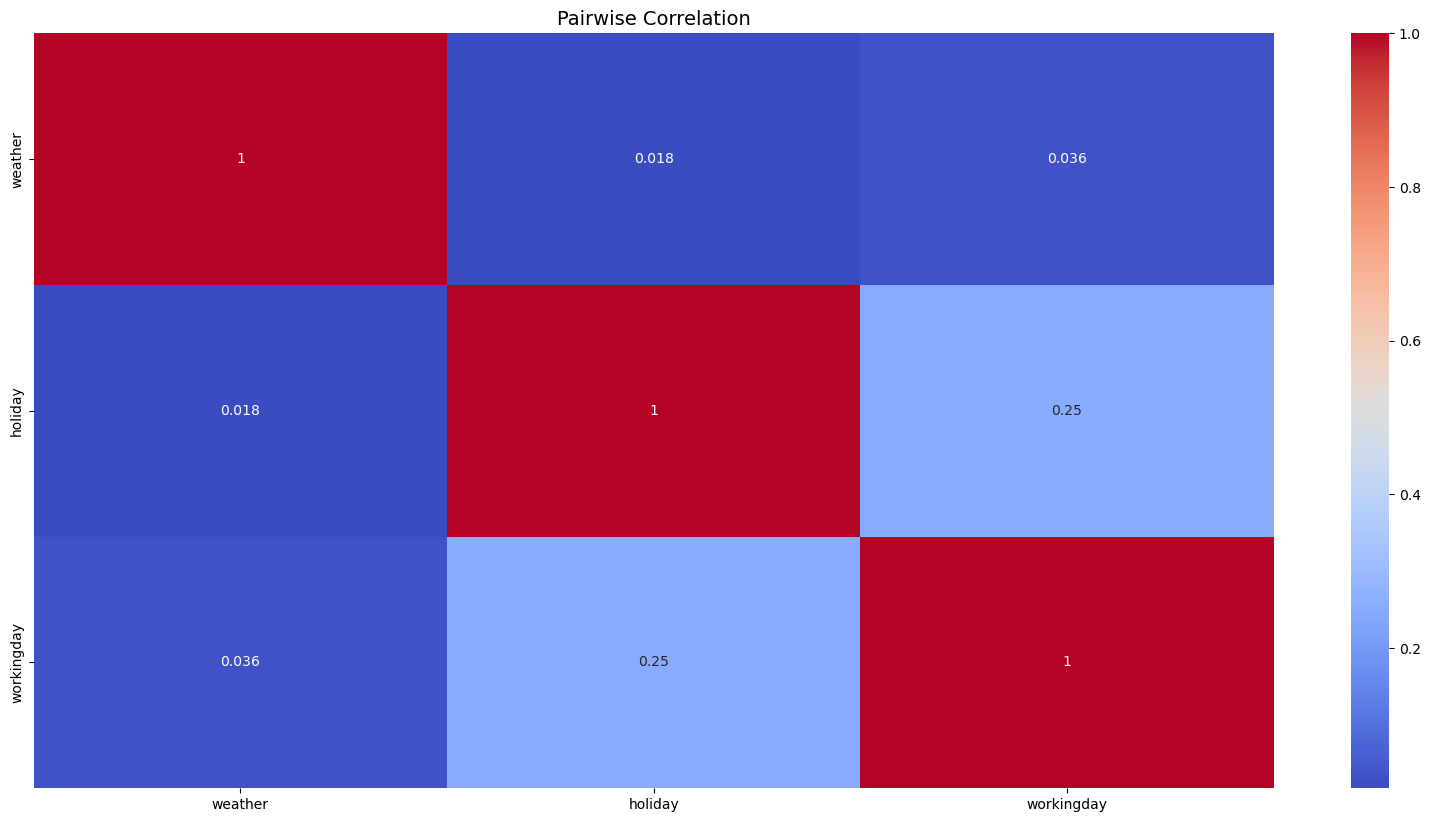

In [1844]:
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(df[['weather','holiday', 'workingday']].corr(cramers_v),cmap='coolwarm',annot=True)
plt.title('Pairwise Correlation', fontsize=14)

In [1845]:
# Correlation ratio: suggested correlation between categorical-numerical features
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

Text(0.5, 1.0, 'Pairwise Correlation')

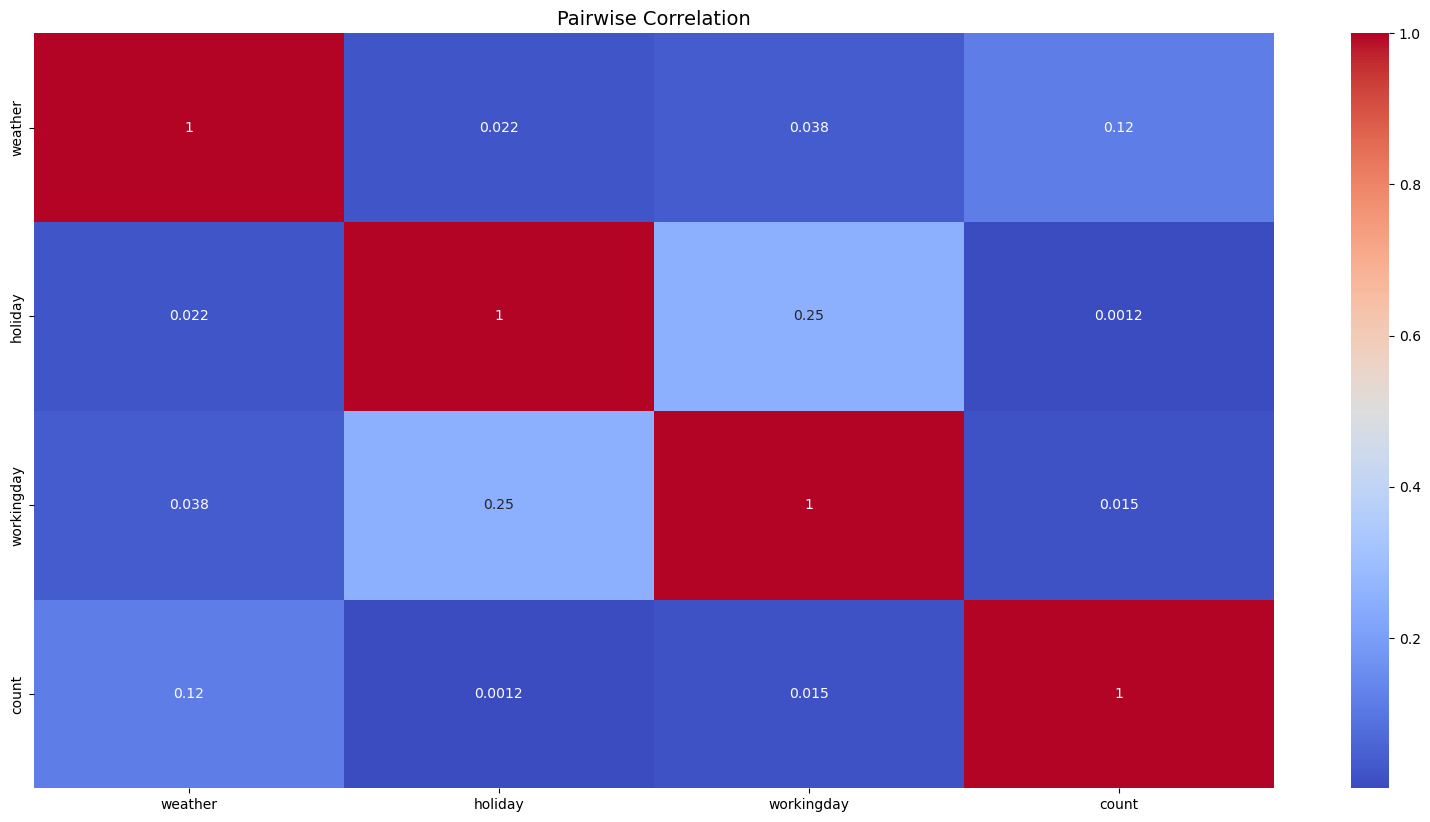

In [1846]:
plt.figure(figsize=(20,10),dpi=100)
sns.heatmap(df[['weather', 'holiday', 'workingday','count']].corr(correlation_ratio),cmap='coolwarm',annot=True)
plt.title('Pairwise Correlation', fontsize=14)

## How does time affect counts

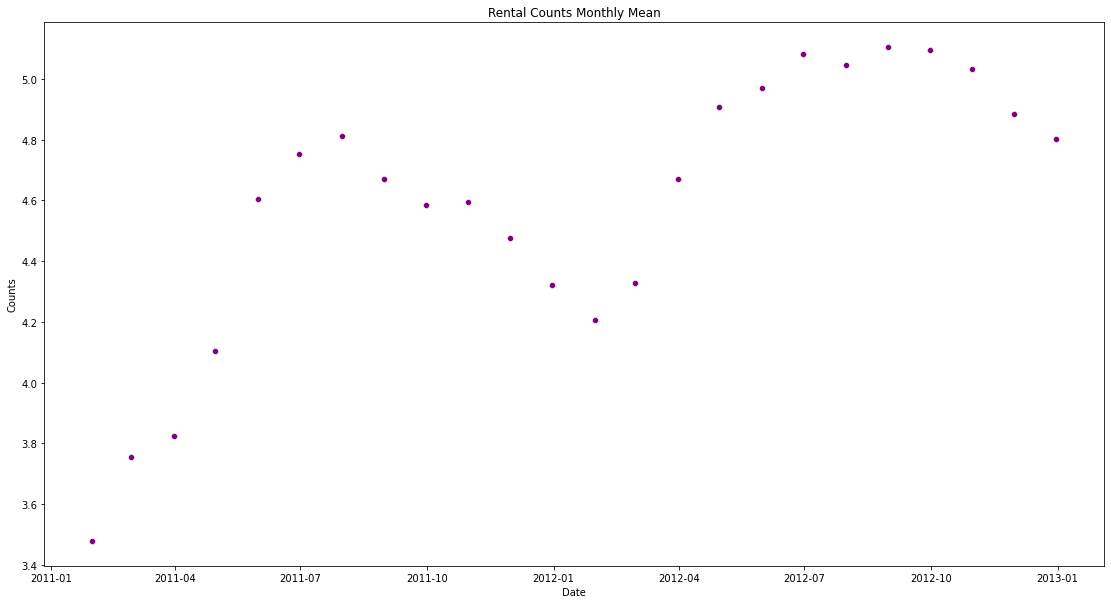

In [1847]:
# monthy average over time
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('M').mean(), x = 'datetime', y ='count', color='purple')
plt.ylabel('Counts')
plt.xlabel('Date')
plt.title('Rental Counts Monthly Mean')
plt.show()

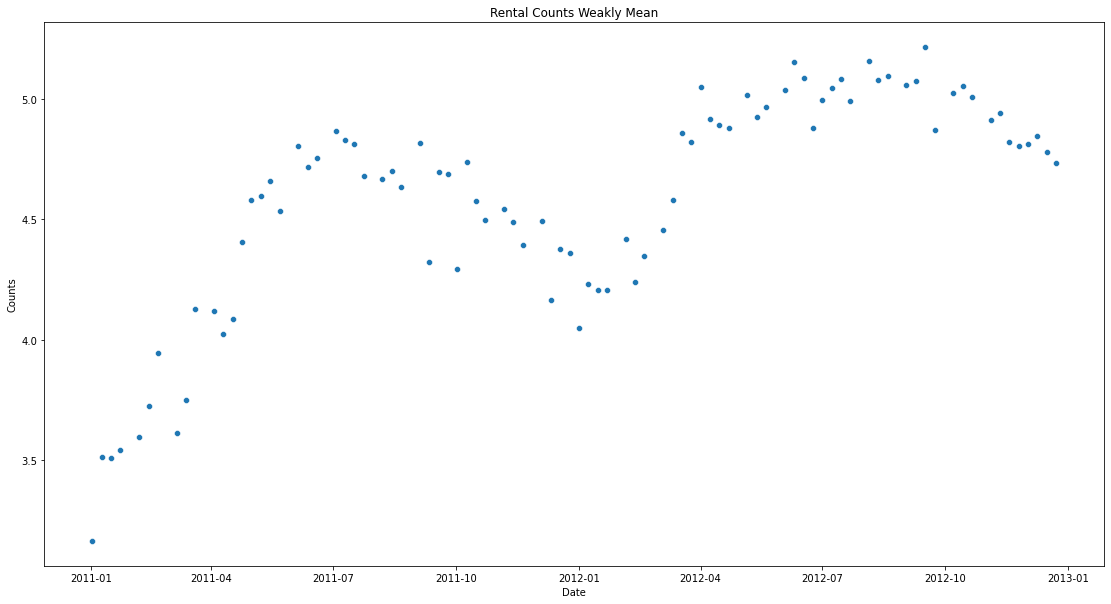

In [1848]:
# Weakly average over time
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('W').mean(), x = 'datetime', y ='count')
plt.ylabel('Counts')
plt.xlabel('Date')
plt.title('Rental Counts Weakly Mean')
plt.show()

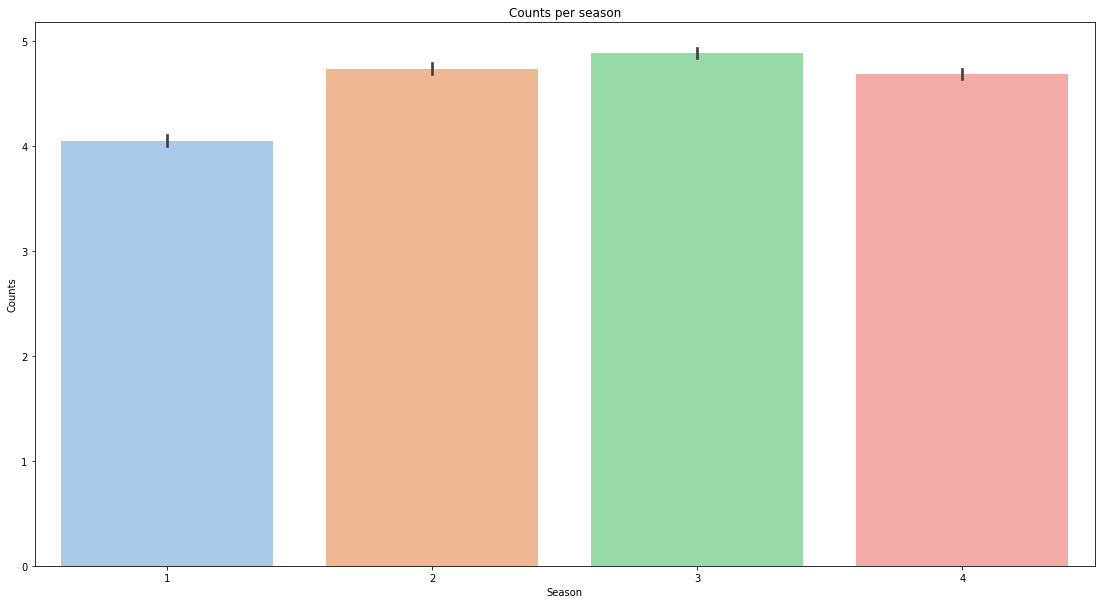

In [1849]:
# season average
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'season', y ='count', palette='pastel', ) 
plt.xlabel('Season')
plt.ylabel('Counts')
plt.title('Counts per season')
plt.show()

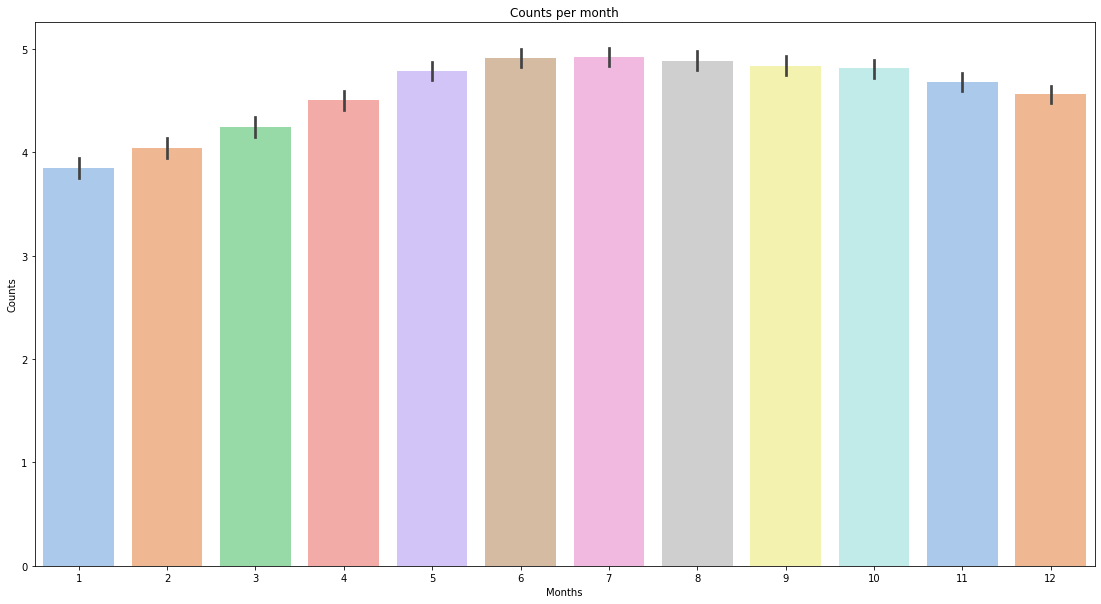

In [1850]:
# monthy average
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'month', y ='count', palette='pastel', ) 
plt.xlabel('Months')
plt.ylabel('Counts')
plt.title('Counts per month')
plt.show()

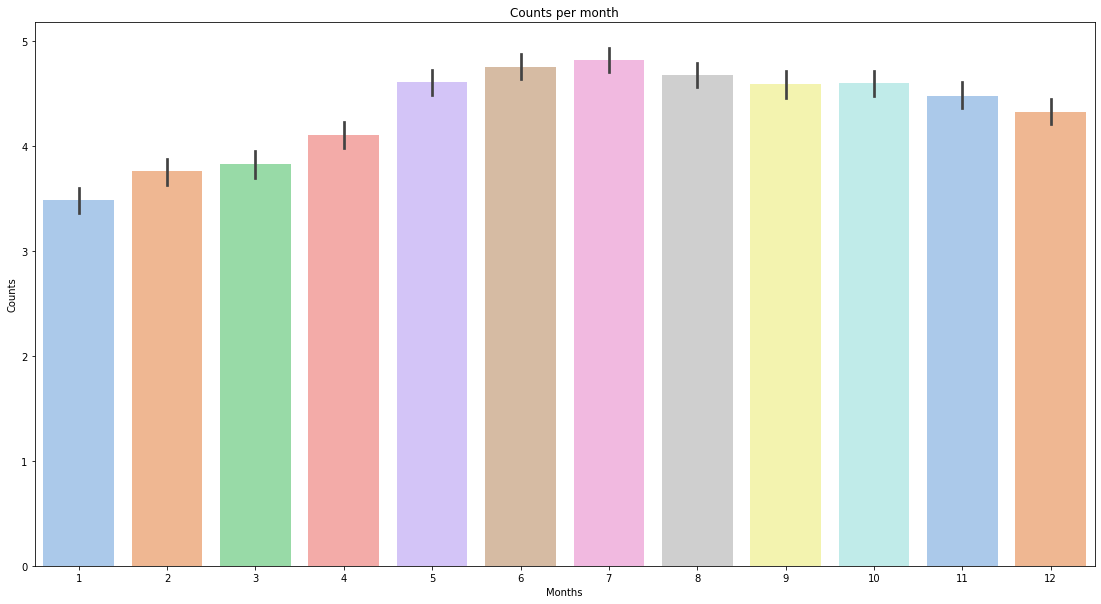

In [1851]:
plt.figure(figsize=(19,10))
sns.barplot(data =df[df['year']==2011], x = 'month', y ='count', palette='pastel', ) 
plt.xlabel('Months')
plt.ylabel('Counts')
plt.title('Counts per month')
plt.show()

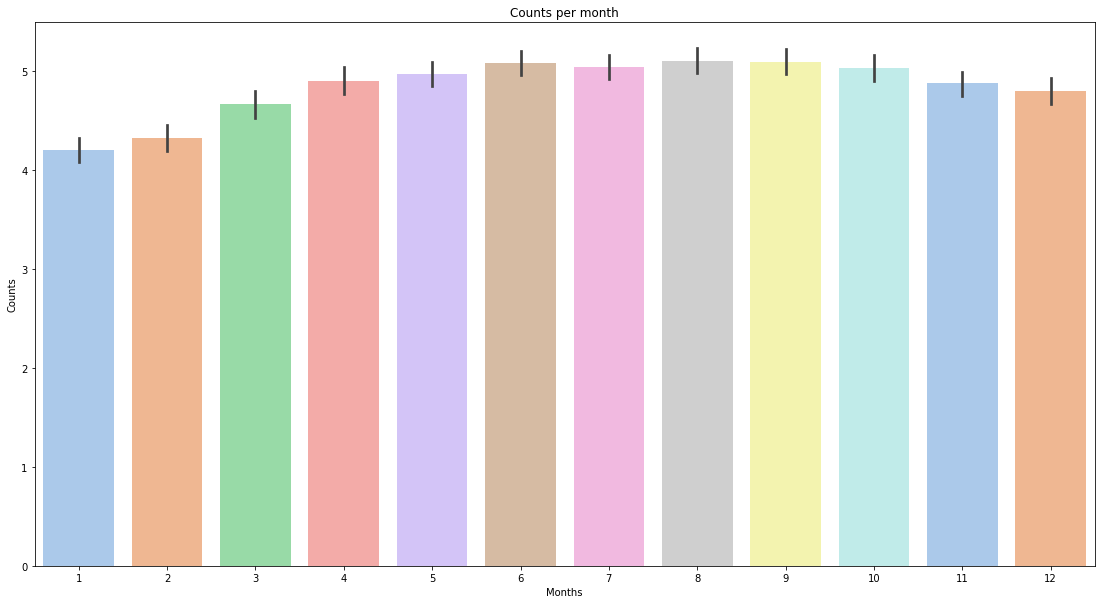

In [1852]:
plt.figure(figsize=(19,10))
sns.barplot(data =df[df['year']==2012], x = 'month', y ='count', palette='pastel', ) 
plt.xlabel('Months')
plt.ylabel('Counts')
plt.title('Counts per month')
plt.show()

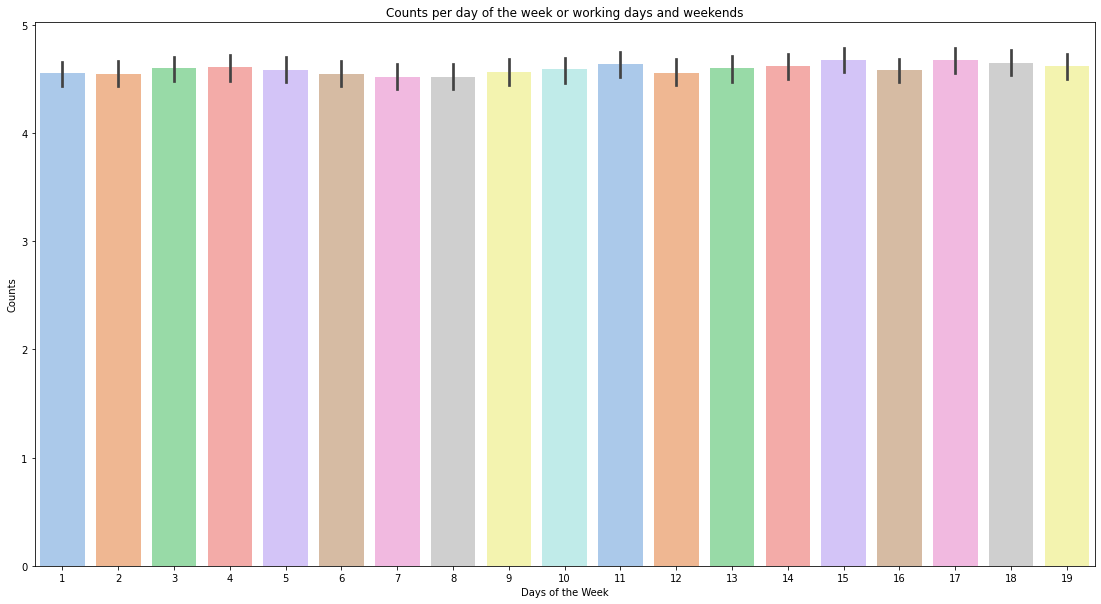

In [1853]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'day', y ='count', palette='pastel', ) 
plt.xlabel('Days of the Week')
plt.ylabel('Counts')
plt.title('Counts per day of the week or working days and weekends')
plt.show()

* We see a clear yearly periodicity and a up going trend
* Data do not contain the last days of the month. For the days we have information, there seems to not be a trend. 

In [1854]:
# create column to count months past to capture treand and yearly periodicity
df['month_count'] = df['month']+(df['year']-2011)*12

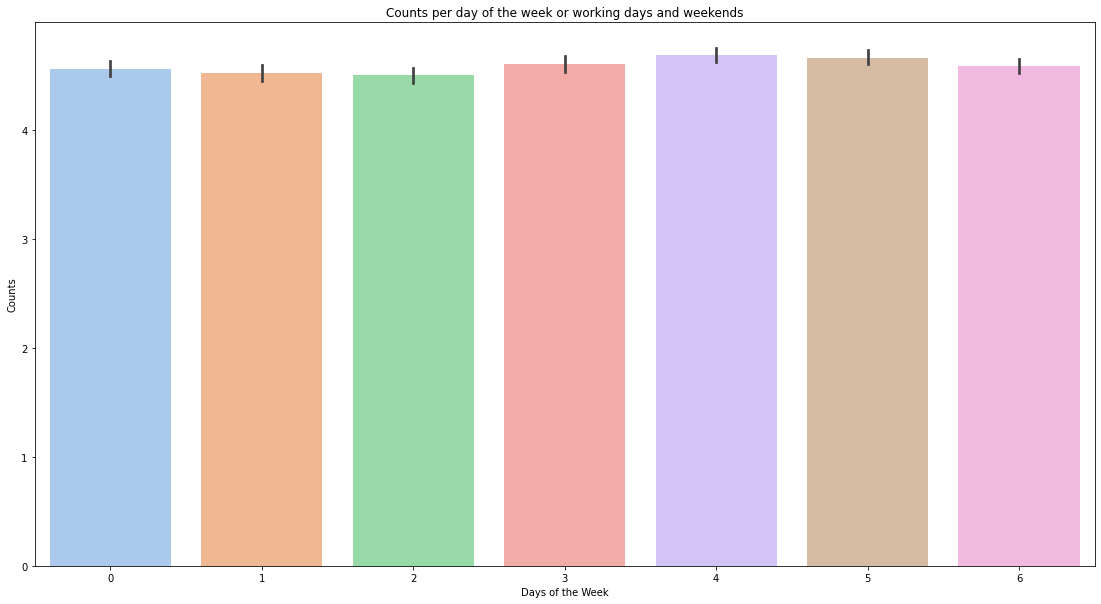

In [1855]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'weekday', y ='count', palette='pastel') 
plt.xlabel('Days of the Week')
plt.ylabel('Counts')
plt.title('Counts per day of the week or working days and weekends')
plt.show()

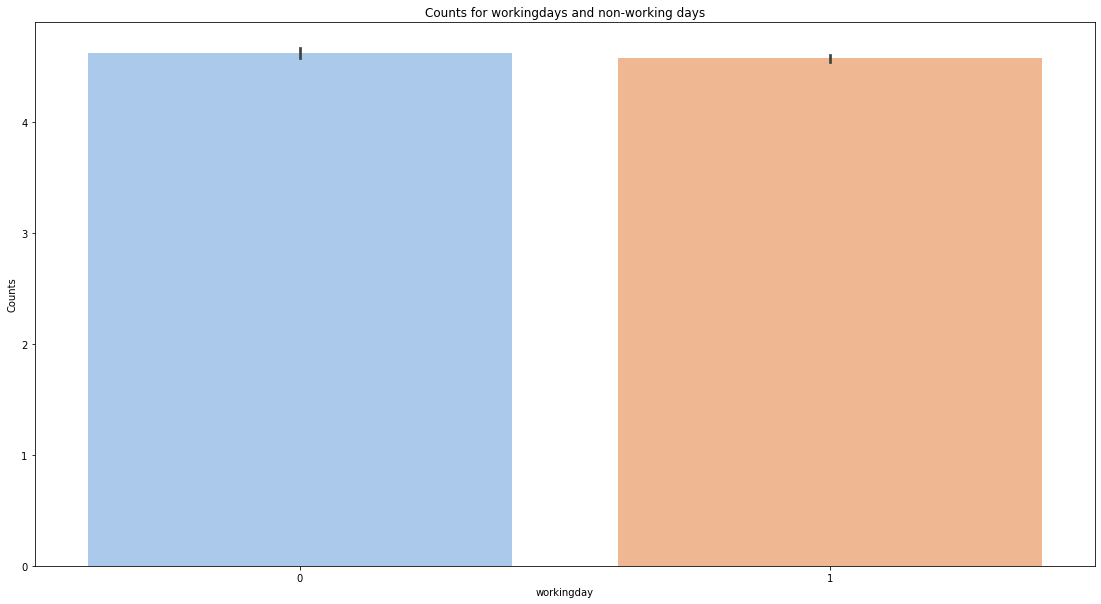

In [1856]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'workingday', y ='count', palette='pastel') 
plt.xlabel('workingday')
plt.ylabel('Counts')
plt.title('Counts for workingdays and non-working days')
plt.show()

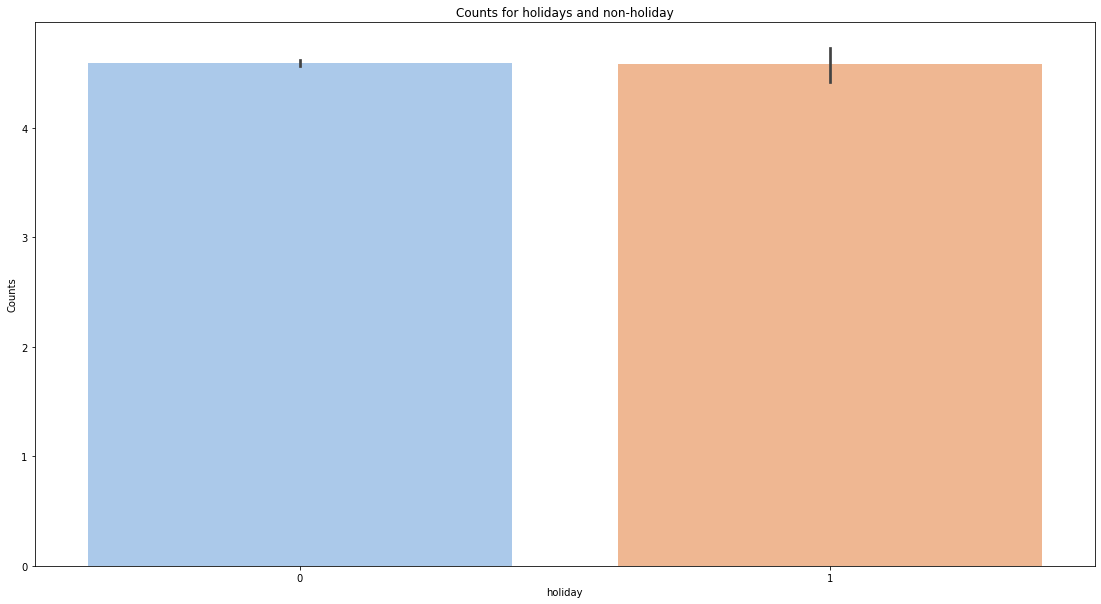

In [1857]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'holiday', y ='count', palette='pastel') 
plt.xlabel('holiday')
plt.ylabel('Counts')
plt.title('Counts for holidays and non-holiday')
plt.show()

* The day of the week does not seem to affect significantly the total count, with a possible exception on Sunday, where counts are slightly reduced.   

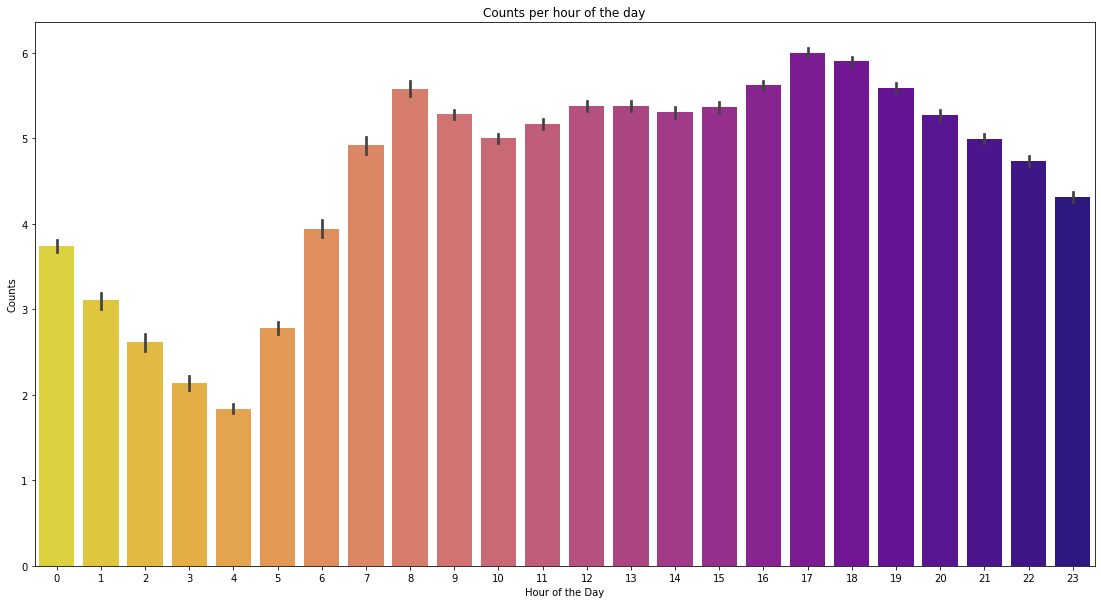

In [1858]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'hour', y ='count',  palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour of the day')
plt.show()

We have now cheacked how each column affects seperatly.

'season': Shows how counts behaviour with seasons. But months are much better for this. Thus we drop it.

'holiday'-'workingday': Separation to working days and non-working days seems enough. We drop holiday.

'weather': Shows clear correlation with counts. Keep.

'temp' Shows clear correlation with counts but also 98% with 'atemp'. Drop

'atemp': If we drop 'temp', keep.

'humidity': Inverse correlated to counts. Keep.

'windspeed': The correlation is not very clear. Drop. 

'hour': Clear correlation with counts and periodicity. Keep 

'day': No significant change on mean counts through out the different days. Drop.

'weekday': Shows some small drop on counts on Sundays. Keep. 

'month'-'year': Show a strong trend and periodicity. Keep.

## Diagrams representing interaction between features

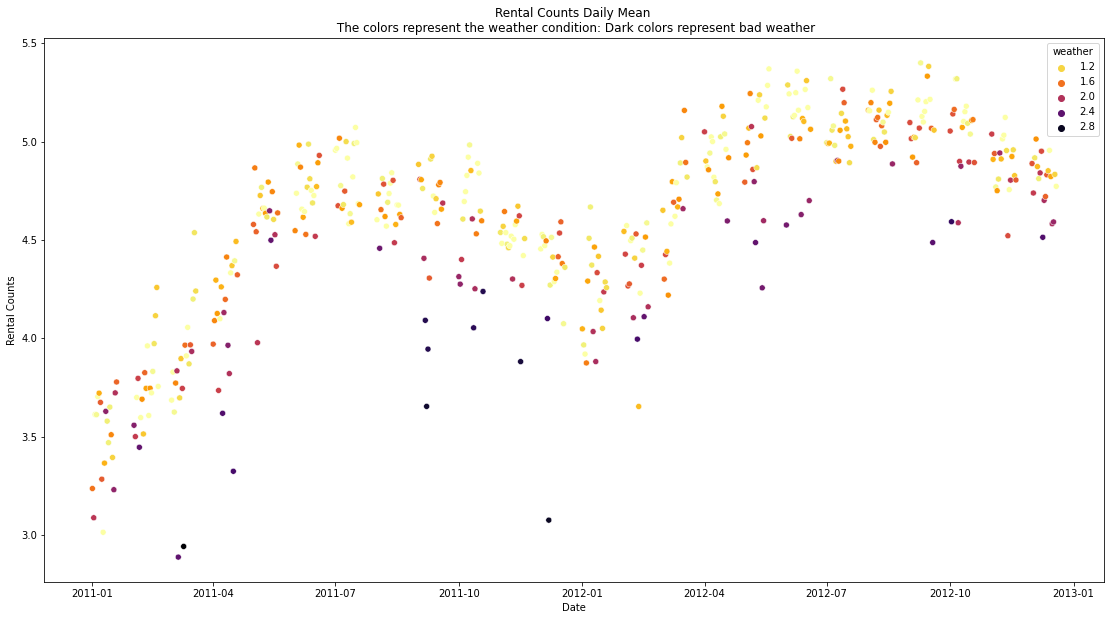

In [1859]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('D').mean(), x = 'datetime', y ='count',hue='weather',palette="inferno_r")
plt.ylabel('Rental Counts')
plt.xlabel('Date')
plt.title('Rental Counts Daily Mean \n The colors represent the weather condition: Dark colors represent bad weather')
plt.show()

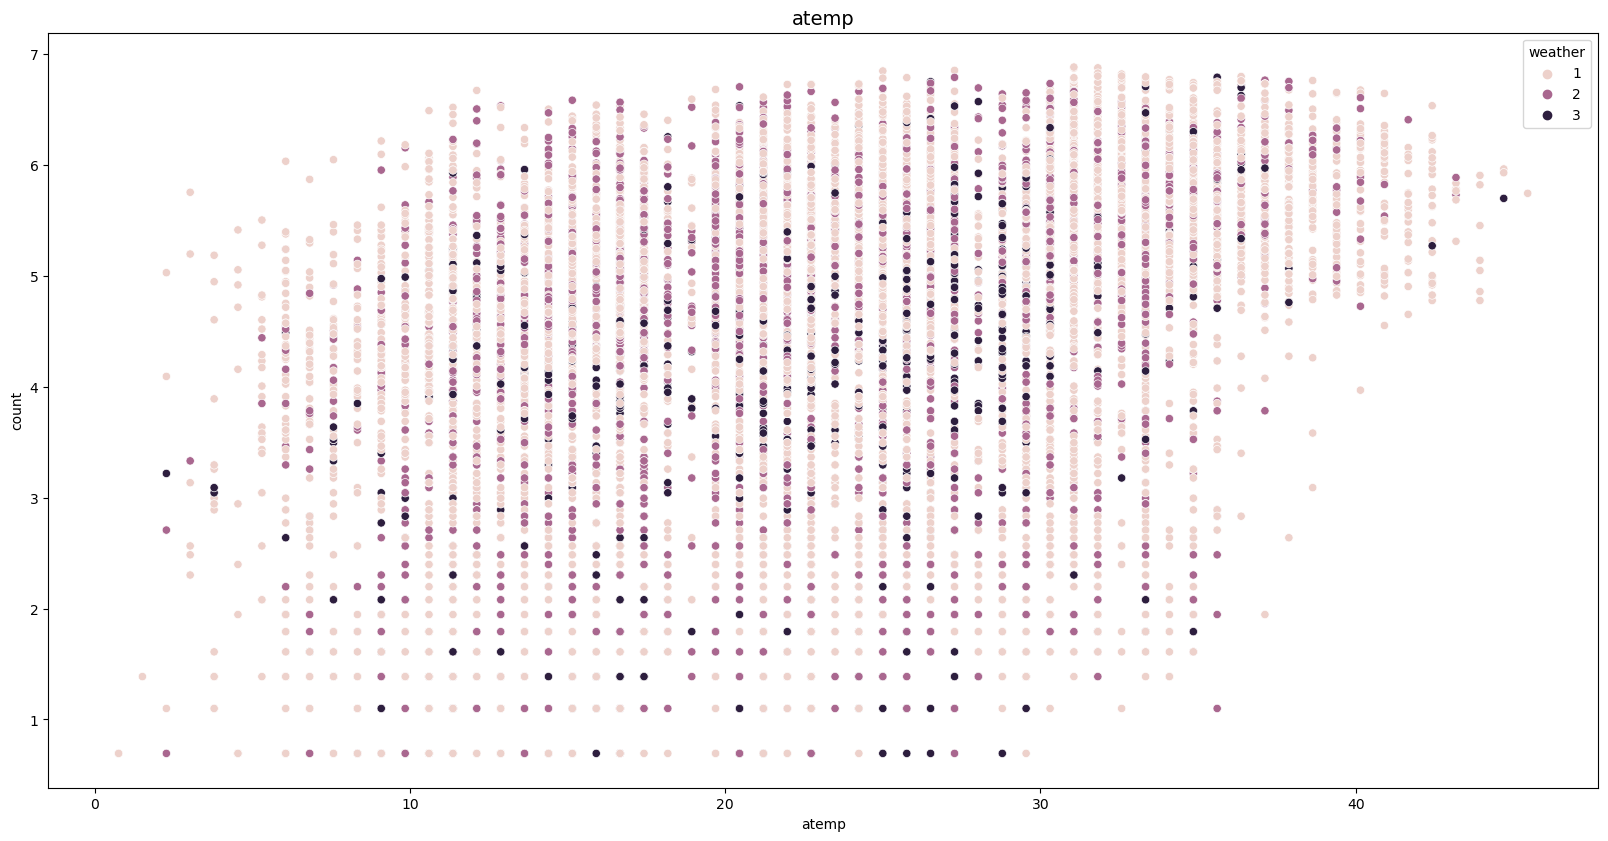

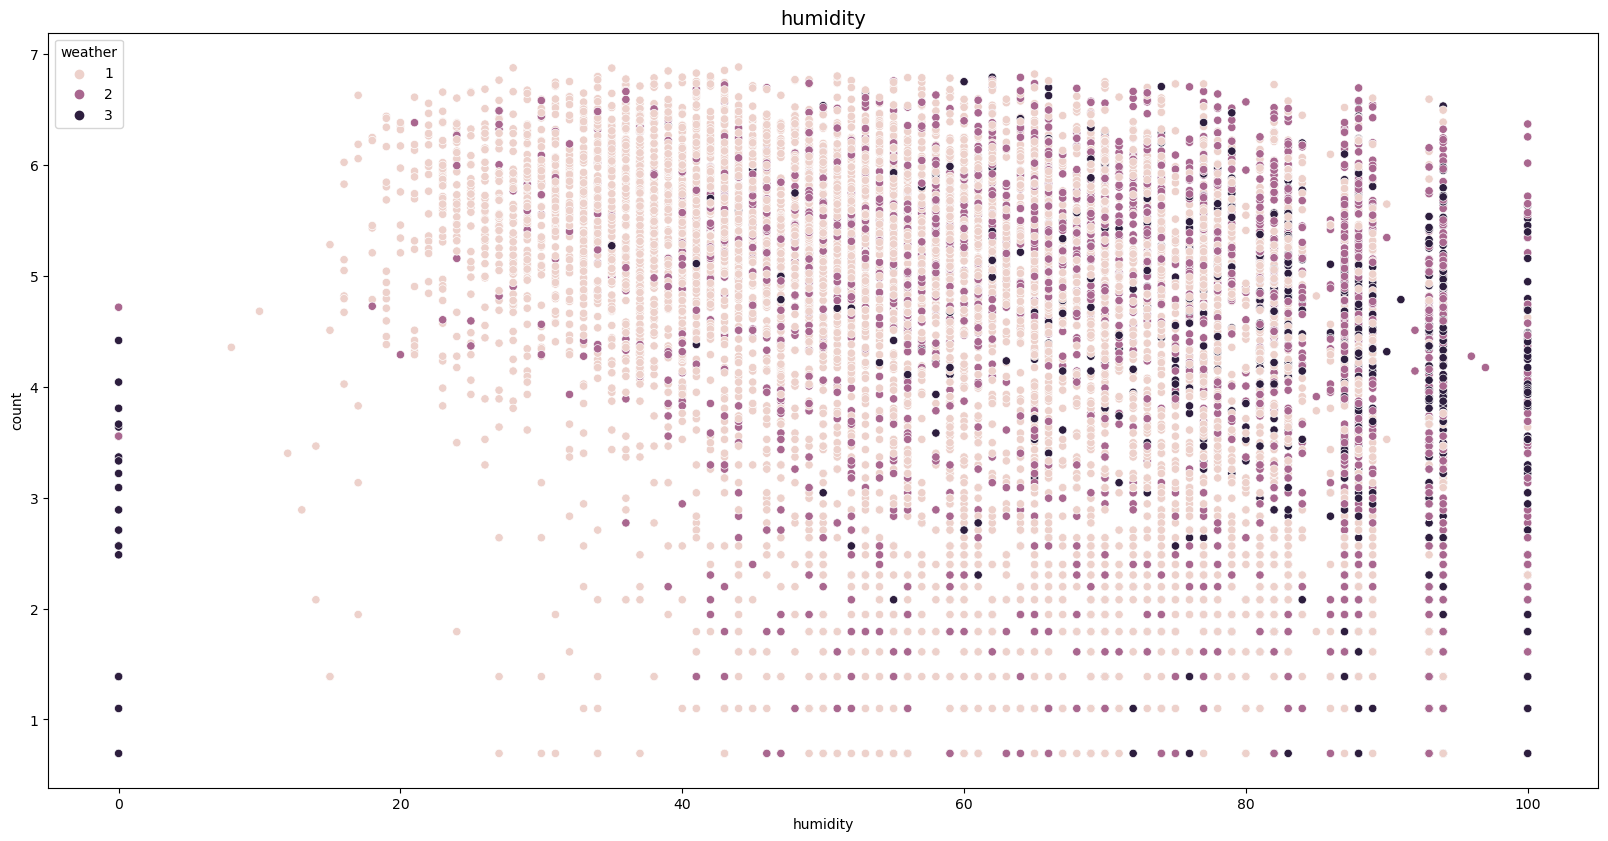

In [1860]:
for column in ['atemp', 'humidity']:
    plt.figure(figsize=(20,10),dpi=100)
    sns.scatterplot(data = df,x=column,y='count', hue='weather', color="purple")
    plt.title(f'{column}', fontsize=14)
    plt.show()

It seems like the zeros in humidity are 100%.

In [1861]:
df['humidity'][df['humidity']<=0.001]=100

/var/folders/c4/jkw5wy1d7lndc6p4y832vmrc0000gn/T/ipykernel_68735/701435664.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['humidity'][df['humidity']<=0.001]=100


In [1862]:
df[['humidity']].describe()

,humidity
count,10886.000000
mean,62.088554
std,19.118725
min,8.000000
25%,47.000000
50%,62.000000
75%,78.000000
max,100.000000


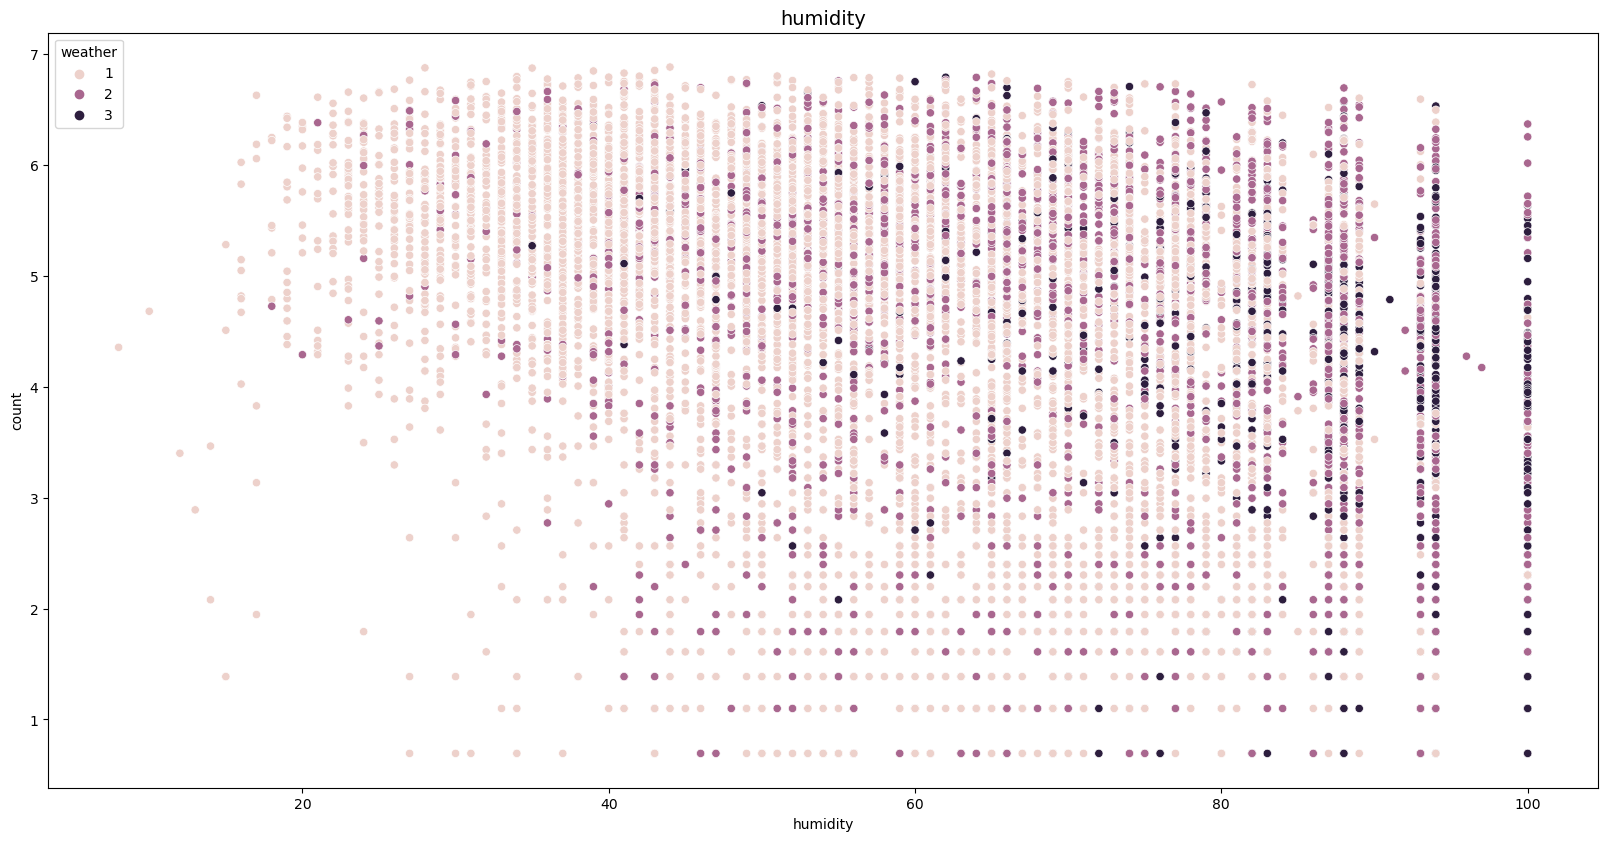

In [1863]:
plt.figure(figsize=(20,10),dpi=100)
sns.scatterplot(data = df,x='humidity',y='count', hue='weather', color="purple")
plt.title(f'humidity', fontsize=14)
plt.show()

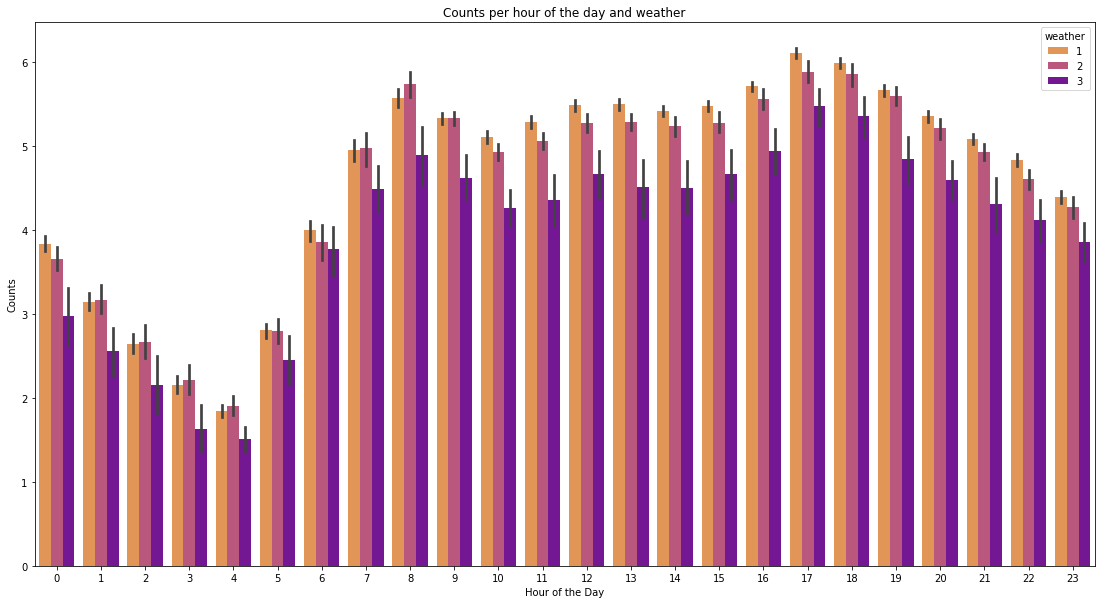

In [1864]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'hour', y ='count', hue = 'weather', palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour of the day and weather')
plt.show()

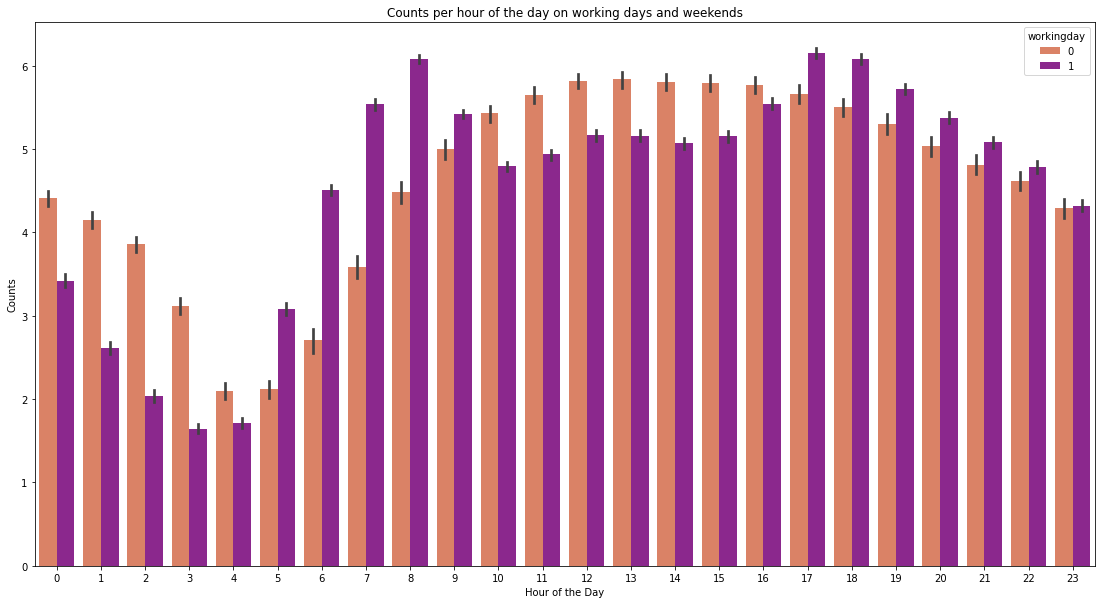

In [1865]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'hour', y ='count', hue = 'workingday', palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour of the day on working days and weekends')
plt.show()

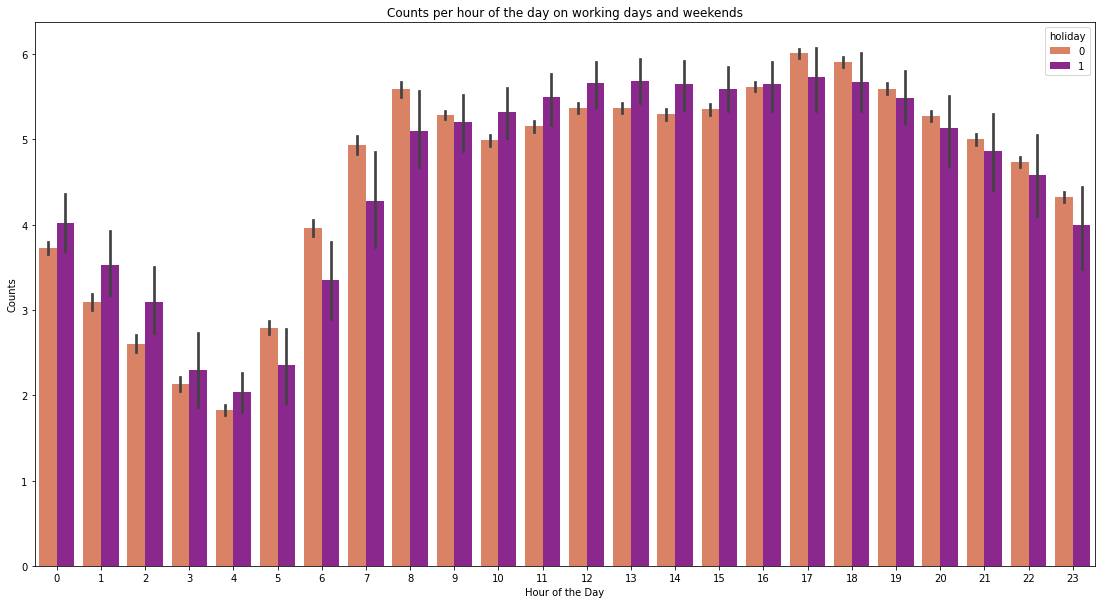

In [1866]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'hour', y ='count', hue = 'holiday', palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour of the day on working days and weekends')
plt.show()

* The hourly behavour changes singificantly between working days and non-working days.  
* Working days, there are picks on 8h and 17h and a fast drop towards the minimum 3-4h, while for non-working days there is a plato between 12h and 16h and then droping slower to the minimum, which now is around 4-5h. 

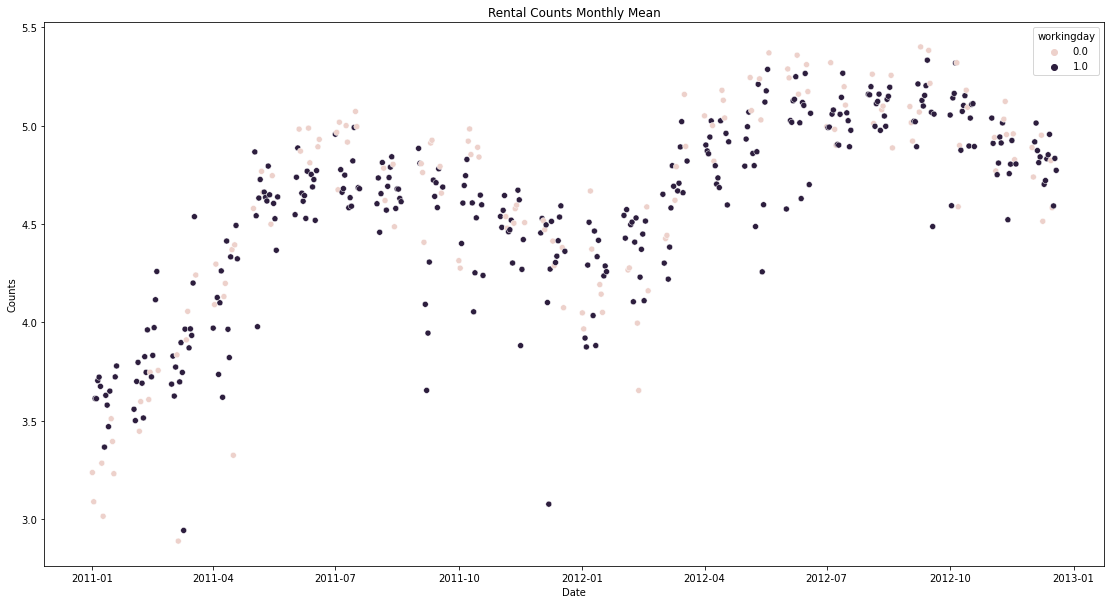

In [1867]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('D').mean(), x = 'datetime', y ='count',hue='workingday')
plt.ylabel('Counts')
plt.xlabel('Date')
plt.title('Rental Counts Monthly Mean')
plt.show()

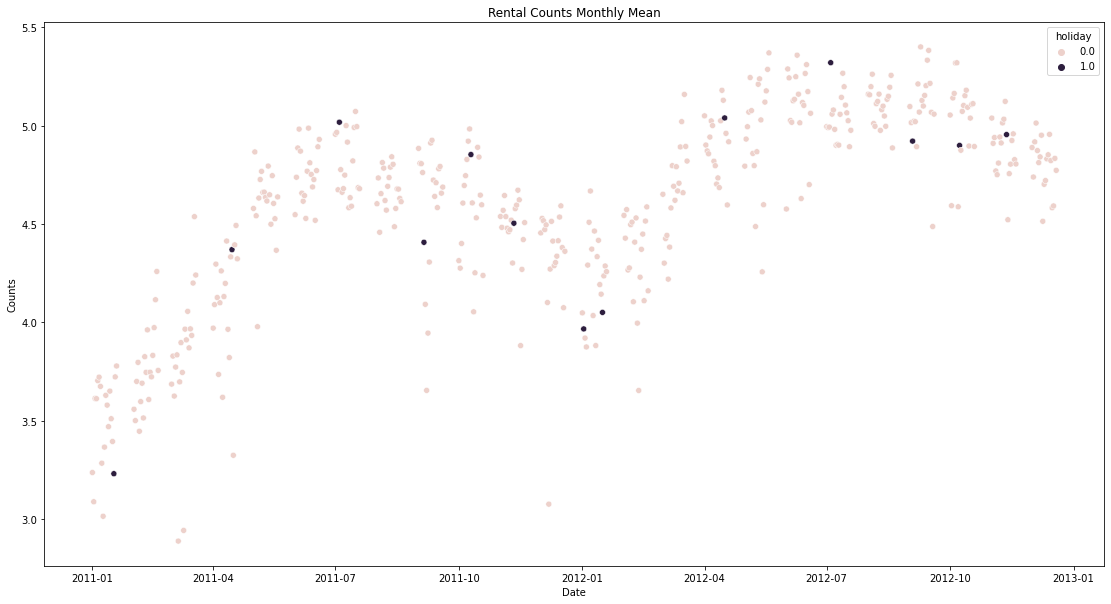

In [1868]:
plt.figure(figsize=(19,10))
sns.scatterplot(data =df.resample('D').mean(), x = 'datetime', y ='count',hue='holiday')
plt.ylabel('Counts')
plt.xlabel('Date')
plt.title('Rental Counts Monthly Mean')
plt.show()

The daily mean does not seem to change for non-working days. But the hourly distribution does! 

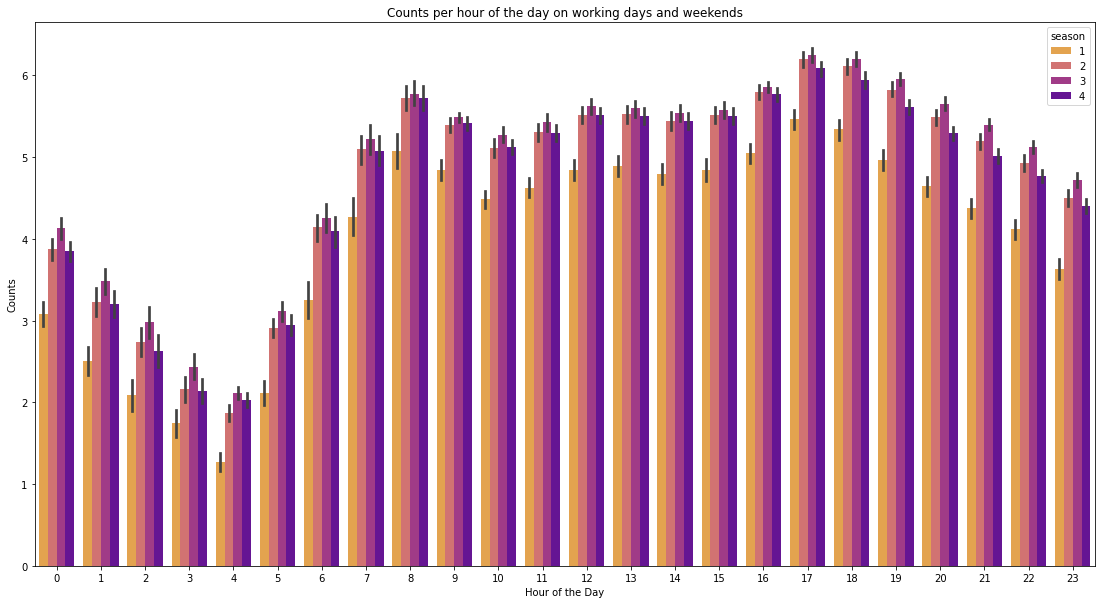

In [1869]:
plt.figure(figsize=(19,10))
sns.barplot(data =df, x = 'hour', y ='count', hue = 'season', palette='plasma_r', )
plt.xlabel('Hour of the Day')
plt.ylabel('Counts')
plt.title('Counts per hour of the day on working days and weekends')
plt.show()

The daily behaviour does not change significantly in different seasons. 

## Feature engineering

In [1870]:
y = df['count']
X = df.drop(columns=[ 'casual', 'registered', 'count'])

In [1871]:
X.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'hour', 'day', 'weekday', 'month', 'year',
       'month_count'],
      dtype='object')

In [1872]:
X = X[['workingday', 'weather', 'atemp', 'humidity',
       'hour','weekday', 'month', 'month_count']]

In [1873]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42) 

In [1874]:
polynomial_pipeline_3 = Pipeline([
    ('num_scaler',StandardScaler()),
    ('polynomial', PolynomialFeatures(degree= 3, include_bias=False)),
])

In [1875]:
polynomial_pipeline_4 = Pipeline([
    ('num_scaler',StandardScaler()),
    ('polynomial', PolynomialFeatures(degree= 4,)),
])

In [1876]:
categorical_pipeline = Pipeline([
    ('categorical_ohe',OneHotEncoder(sparse=False)),
    #('interactions',PolynomialFeatures(degree= 2, interaction_only=True, include_bias=False))
])

In [1877]:
X_train

,workingday,weather,atemp,humidity,hour,weekday,month,month_count
datetime,,,,,,,,
2011-07-06 05:00:00,1,1,31.820,83,5,2,7,7
2012-08-04 16:00:00,0,1,40.910,39,16,5,8,20
2012-07-11 15:00:00,1,1,35.605,41,15,2,7,19
2011-04-10 04:00:00,0,2,18.180,93,4,6,4,4
2011-11-19 10:00:00,0,1,15.150,45,10,5,11,11
...,...,...,...,...,...,...,...,...
2012-01-14 02:00:00,0,1,8.335,47,2,5,1,13
2011-12-10 09:00:00,0,1,12.880,61,9,5,12,12
2011-12-18 16:00:00,0,1,13.635,48,16,6,12,12


In [1878]:
X_train['hour-weekday']=X_train['hour']*X_train['weekday']
X_train['hour-workingday']=X_train['hour']*X_train['workingday']
X_train['hour-workingday']=X_train['hour']*X_train['workingday']

In [1879]:
X_test['hour-weekday']=X_test['hour']*X_test['weekday']
X_test['hour-workingday']=X_test['hour']*X_test['workingday']

In [1880]:
X_train.head()

,workingday,weather,atemp,humidity,hour,weekday,month,month_count,hour-weekday,hour-workingday
datetime,,,,,,,,,,
2011-07-06 05:00:00,1,1,31.820,83,5,2,7,7,10,5
2012-08-04 16:00:00,0,1,40.910,39,16,5,8,20,80,0
2012-07-11 15:00:00,1,1,35.605,41,15,2,7,19,30,15
2011-04-10 04:00:00,0,2,18.180,93,4,6,4,4,24,0
2011-11-19 10:00:00,0,1,15.150,45,10,5,11,11,50,0


In [1881]:
column_transformer = ColumnTransformer([
    ('poly_3a',polynomial_pipeline_3,['atemp']), 
    ('poly_3b',polynomial_pipeline_3,['humidity']),
    ('poly_4', polynomial_pipeline_4, ['month_count',]),
    ('categorical_pipeline',categorical_pipeline,['hour', 'weekday', 'workingday', 'weather','hour-weekday','hour-workingday',]),
])

In [1882]:
column_transformer.fit(X_train) 
X_train_1 = column_transformer.transform(X_train) 
X_test_1 = column_transformer.transform(X_test)

In [1883]:
X_train_fe=pd.DataFrame(X_train_1, columns=column_transformer.get_feature_names_out())
X_test_fe=pd.DataFrame(X_test_1, columns=column_transformer.get_feature_names_out())
X_train_fe.columns

Index(['poly_3a__atemp', 'poly_3a__atemp^2', 'poly_3a__atemp^3',
       'poly_3b__humidity', 'poly_3b__humidity^2', 'poly_3b__humidity^3',
       'poly_4__1', 'poly_4__month_count', 'poly_4__month_count^2',
       'poly_4__month_count^3',
       ...
       'categorical_pipeline__hour-workingday_14',
       'categorical_pipeline__hour-workingday_15',
       'categorical_pipeline__hour-workingday_16',
       'categorical_pipeline__hour-workingday_17',
       'categorical_pipeline__hour-workingday_18',
       'categorical_pipeline__hour-workingday_19',
       'categorical_pipeline__hour-workingday_20',
       'categorical_pipeline__hour-workingday_21',
       'categorical_pipeline__hour-workingday_22',
       'categorical_pipeline__hour-workingday_23'],
      dtype='object', length=152)

In [1884]:
X_test_fe.columns[0:20]

Index(['poly_3a__atemp', 'poly_3a__atemp^2', 'poly_3a__atemp^3',
       'poly_3b__humidity', 'poly_3b__humidity^2', 'poly_3b__humidity^3',
       'poly_4__1', 'poly_4__month_count', 'poly_4__month_count^2',
       'poly_4__month_count^3', 'poly_4__month_count^4',
       'categorical_pipeline__hour_0', 'categorical_pipeline__hour_1',
       'categorical_pipeline__hour_2', 'categorical_pipeline__hour_3',
       'categorical_pipeline__hour_4', 'categorical_pipeline__hour_5',
       'categorical_pipeline__hour_6', 'categorical_pipeline__hour_7',
       'categorical_pipeline__hour_8'],
      dtype='object')

In [1885]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_fe,y_train)

DummyRegressor()

In [1886]:
y_pred = dummy_regr.predict(X_test_fe)
ypred = np.exp(y_pred)-1
ytrue = np.exp(y_test)-1
mean_squared_log_error(ytrue, ypred)

2.0586510881259428

In [1887]:
def my_scoring(ytrue_in, ypred_in):
    exp_ypred = np.exp(ypred_in)-1
    exp_ytrue = np.exp(ytrue_in)-1
    return mean_squared_log_error(exp_ytrue, exp_ypred)
score = make_scorer(my_scoring, greater_is_better=False)

In [1889]:
parameters={
    #'alpha': np.linspace(0.0001,2,5),
    'alpha': np.linspace(0.01,0.1,5),
    #'degree':[1,2,3]
    'degree':[2]
}
kernel_ridge_tuned = GridSearchCV(
    KernelRidge(kernel='poly'),
    param_grid=parameters,
    scoring=score,
    verbose=2
)
kernel_ridge_tuned.fit(X_train_fe,y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ...............................alpha=0.01, degree=2; total time=   5.9s
[CV] END ...............................alpha=0.01, degree=2; total time=   5.8s


/Users/maria/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/maria/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/maria/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 216, in __call__
    return self._score(
  File "/Users/maria/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 264, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/var/folders/c4/jkw5wy1d7lndc6p4y832vmrc0000gn/T/ipykernel_68735/113227955.py", line 4, in my_scoring
    return mean_squared_log_error(exp_ytrue, exp_ypred)
  File "/Users/maria/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regress

[CV] END ...............................alpha=0.01, degree=2; total time=   5.7s
[CV] END ...............................alpha=0.01, degree=2; total time=   6.4s
[CV] END ...............................alpha=0.01, degree=2; total time=   5.0s
[CV] END .............................alpha=0.0325, degree=2; total time=   5.5s
[CV] END .............................alpha=0.0325, degree=2; total time=   4.9s
[CV] END .............................alpha=0.0325, degree=2; total time=   5.6s
[CV] END .............................alpha=0.0325, degree=2; total time=   4.9s
[CV] END .............................alpha=0.0325, degree=2; total time=   6.3s
[CV] END ................alpha=0.05500000000000001, degree=2; total time=   5.0s
[CV] END ................alpha=0.05500000000000001, degree=2; total time=   5.5s
[CV] END ................alpha=0.05500000000000001, degree=2; total time=   4.9s
[CV] END ................alpha=0.05500000000000001, degree=2; total time=   5.7s
[CV] END ................alp

/Users/maria/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [        nan -0.09549705 -0.09799122 -0.10058838 -0.10319656]
  warnings.warn(


GridSearchCV(estimator=KernelRidge(kernel='poly'),
             param_grid={'alpha': array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ]),
                         'degree': [2]},
             scoring=make_scorer(my_scoring, greater_is_better=False),
             verbose=2)

In [1890]:
kernel_ridge_tuned.best_score_

-0.09549704731016176

In [1891]:
kernel_ridge_tuned.best_params_

{'alpha': 0.0325, 'degree': 2}

In [1892]:
ypredlog = kernel_ridge_tuned.predict((X_test_fe))
ypred = np.exp(ypredlog)-1

In [1893]:
np.where(ypred<0)

(array([], dtype=int64),)

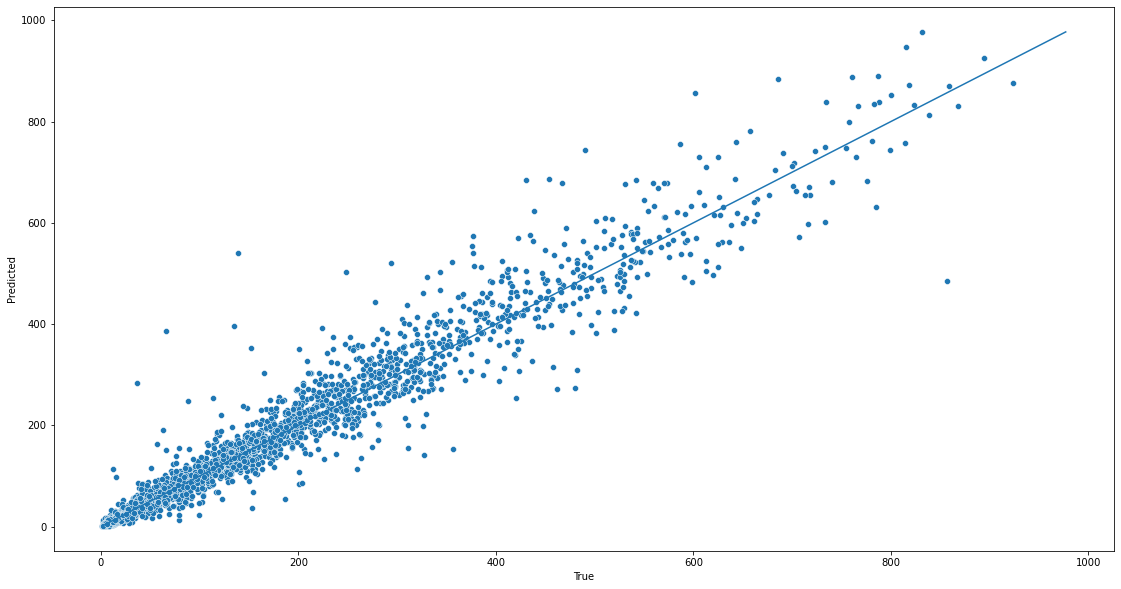

In [1894]:
plt.figure(figsize=(19,10))
sns.scatterplot(y=ytrue, x=ypred)
plt.xlabel('True')
plt.ylabel('Predicted')
# We also plot a diagonal line to show where the prediction should end up.
sns.lineplot(x=ytrue,y=ytrue)
plt.show()

In [1895]:
parameters={
    #'alpha': np.logspace(-11,0,5),
    'alpha': np.linspace(0.0005,0.01,5),
    #'gamma':np.logspace(-11,0,5),
    'gamma': np.linspace(0.0005,0.01,5),
}
kernel_ridge_tuned = GridSearchCV(
    KernelRidge(kernel='rbf'),
    param_grid=parameters,
    scoring=score,
    verbose=2
)
kernel_ridge_tuned.fit(X_train_fe,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .........................alpha=0.0005, gamma=0.0005; total time=   8.1s
[CV] END .........................alpha=0.0005, gamma=0.0005; total time=   5.7s
[CV] END .........................alpha=0.0005, gamma=0.0005; total time=   6.6s
[CV] END .........................alpha=0.0005, gamma=0.0005; total time=   5.7s
[CV] END .........................alpha=0.0005, gamma=0.0005; total time=   6.5s
[CV] END .......................alpha=0.0005, gamma=0.002875; total time=   5.8s
[CV] END .......................alpha=0.0005, gamma=0.002875; total time=   6.4s
[CV] END .......................alpha=0.0005, gamma=0.002875; total time=   5.6s
[CV] END .......................alpha=0.0005, gamma=0.002875; total time=   6.6s
[CV] END .......................alpha=0.0005, gamma=0.002875; total time=   5.6s
[CV] END ..........alpha=0.0005, gamma=0.0052499999999999995; total time=   6.7s
[CV] END ..........alpha=0.0005, gamma=0.005249

GridSearchCV(estimator=KernelRidge(kernel='rbf'),
             param_grid={'alpha': array([0.0005  , 0.002875, 0.00525 , 0.007625, 0.01    ]),
                         'gamma': array([0.0005  , 0.002875, 0.00525 , 0.007625, 0.01    ])},
             scoring=make_scorer(my_scoring, greater_is_better=False),
             verbose=2)

In [ ]:
kernel_ridge_tuned.best_score_

-0.09338149959953387

In [ ]:
kernel_ridge_tuned.best_params_

{'alpha': 0.002875, 'gamma': 0.002875}

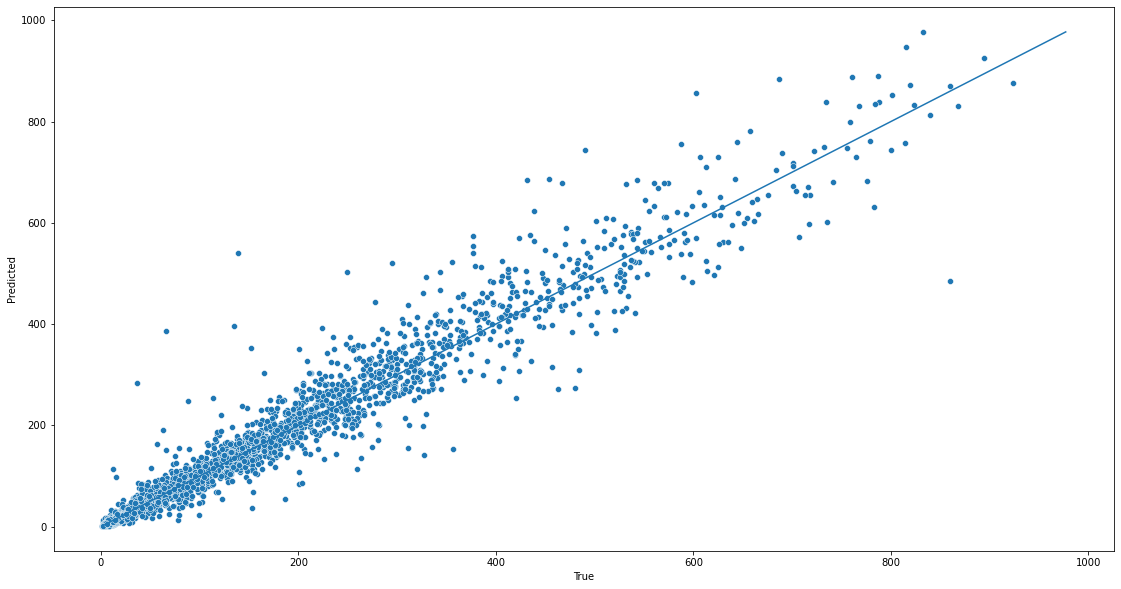

In [ ]:
plt.figure(figsize=(19,10))
sns.scatterplot(y=ytrue, x=ypred)
plt.xlabel('True')
plt.ylabel('Predicted')
# We also plot a diagonal line to show where the prediction should end up.
sns.lineplot(x=ytrue,y=ytrue)
plt.show()

In [ ]:
df = pd.read_csv('data/test.csv', index_col=0, parse_dates=True)
df.shape

(6493, 8)

In [ ]:
df['hour'] = df.index.hour
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['month'] = df.index.month
df['year'] = df.index.year
df['month_count'] = df['month']+(df['year']-2011)*12
df.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'hour', 'day', 'weekday', 'month', 'year',
       'month_count'],
      dtype='object')

In [ ]:
df['humidity'].describe()

count    6493.000000
mean       64.125212
std        19.293391
min        16.000000
25%        49.000000
50%        65.000000
75%        81.000000
max       100.000000
Name: humidity, dtype: float64

In [ ]:
df['weather'].describe()

count    6493.000000
mean        1.436778
std         0.648390
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: weather, dtype: float64

In [ ]:
df['weather'] = df['weather'].replace(4, 3)

In [ ]:
df['hour-weekday']=df['hour']*df['weekday']
df['hour-workingday']=df['hour']*df['workingday']

In [ ]:
X = df[['workingday', 'weather', 'atemp', 'humidity',
       'hour','weekday', 'month', 'month_count', 'hour-weekday', 'hour-workingday',]]

In [ ]:
X_1 = column_transformer.transform(X) 

In [ ]:
X_kaggle=pd.DataFrame(X_1, columns=column_transformer.get_feature_names_out())

In [ ]:
y_predlog_k = kernel_ridge_tuned.predict(X_kaggle)
#y_predlog_k = m.predict(X_kaggle)
ypred_k = np.exp(y_predlog_k)-1

In [ ]:
np.where(ypred_k<0)

(array([], dtype=int64),)

In [ ]:
df_s = pd.read_csv('data/sampleSubmission.csv', index_col=0, parse_dates=True)
df_s['count'] = ypred_k
pd.DataFrame(df_s).to_csv("predictions")